In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_sp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/enc_test_512.npy')
stim_pred = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/pred_test_512.npy')
stim_y = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/y_test_512.npy')
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/resp_test_512.npy')

In [4]:
stim_err = stim_y - stim_pred
stim_spec = np.concatenate((stim_sp, stim_err), axis=1)

In [5]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 544), (5706, 214, 32))

In [6]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [7]:
nsegbins = 32

In [8]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [9]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 544), (5706, 214))

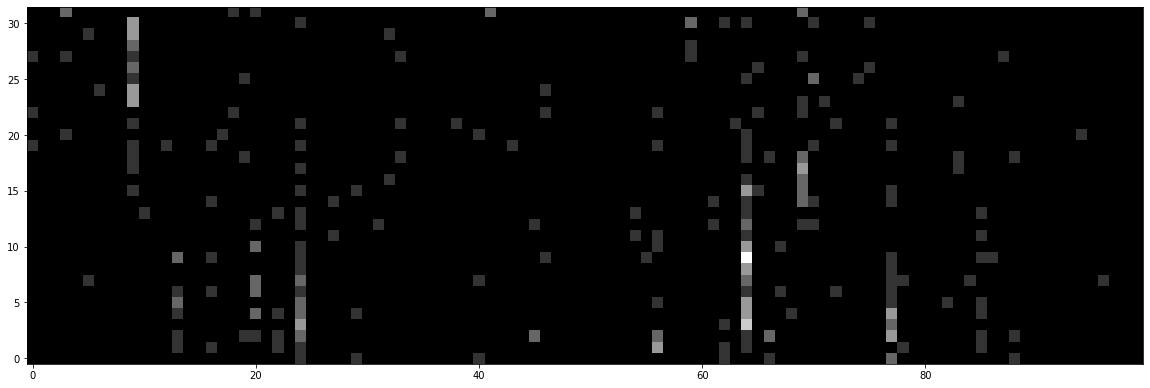

In [10]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [11]:
len_units = np.shape(resp_mne)[1]

In [12]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy'))

In [13]:
exp_path = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/error_mne/'

In [14]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 512
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.155711
    2       0    0.150416
    3       0    0.144626
    4       0    0.143124
    5       0    0.142867
    6       0    0.139594
    7       0    0.138721
    8       0    0.138821
    9       1    0.139426
   10       2    0.136894
   11       0    0.136436
   12       0    0.138181
   13       1    0.138277
   14       2    0.139364
   15       3    0.139503
   16       4    0.140387
   17       5    0.139627
   18       6    0.139635
   19       7    0.139399
   20       8    0.139883
   21       9    0.139634
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.183544
    2       0    0.180216
    3       0    0.161526
    4       0    0.156381
    5       0    0.154414
    6       0    0.155961
    7       1    0.155879
    8       2    0.152502
    9       0    0.152819
   10       1    0.151499
   11       0    0.150667
   12       0    0.149772
   13       0    0.153055
   14       1    0.155478
   15       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.154309
    2       0    0.144534
    3       0    0.140015
    4       0    0.138602
    5       0    0.134231
    6       0    0.131051
    7       0    0.130736
    8       0    0.129048
    9       0    0.130849
   10       1    0.129718
   11       2    0.129828
   12       3    0.128339
   13       0    0.128476
   14       1    0.128399
   15       2    0.127485
   16       0    0.128408
   17       1    0.127957
   18       2    0.128770
   19       3    0.128148
   20       4    0.128439
   21       5    0.128116
   22       6    0.128825
   23       7    0.128446
   24       8    0.128407
   25       9    0.128795
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.154029
    2       0    0.144286
    3       0    0.140654
    4       0    0.138648
    5       0    0.135729
    6       0    0.131783
    7       0    0.132634
    8       1    0.133434
    9       2    0.131152
   10       0    0.129801
   11       0    0.132377
   12       

   22       0    0.089812
   23       1    0.089635
   24       2    0.089814
   25       3    0.089607
   26       4    0.089463
   27       0    0.089632
   28       1    0.089608
   29       2    0.089739
   30       3    0.089991
   31       4    0.089936
   32       5    0.090192
   33       6    0.090211
   34       7    0.089954
   35       8    0.089924
   36       9    0.090171
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.095101
    2       0    0.094051
    3       0    0.090792
    4       0    0.089950
    5       0    0.090259
    6       1    0.090022
    7       2    0.088920
    8       0    0.088264
    9       0    0.088089
   10       0    0.088171
   11       1    0.087454
   12       0    0.087404
   13       0    0.087185
   14       0    0.086667
   15       0    0.086353
   16       0    0.086136
   17       0    0.086288
   18       1    0.086235
   19       2    0.086044
   20       0    0.086187
   21       1    0.086275
   22       

   24       5    0.094243
   25       6    0.095113
   26       7    0.095289
   27       8    0.095246
   28       9    0.095336
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109250
    2       0    0.103011
    3       0    0.102235
    4       0    0.100214
    5       0    0.100940
    6       1    0.100372
    7       2    0.098738
    8       0    0.098380
    9       0    0.099456
   10       1    0.099026
   11       2    0.098636
   12       3    0.098229
   13       0    0.097982
   14       0    0.098972
   15       1    0.098818
   16       2    0.098899
   17       3    0.098593
   18       4    0.098024
   19       5    0.098346
   20       6    0.098767
   21       7    0.098510
   22       8    0.098863
   23       9    0.099444
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.094171
    2       0    0.091473
    3       0    0.090005
    4       0    0.090532
    5       1    0.088835
    6       0    0.087924
    7       

   12       0    0.111430
   13       0    0.111009
   14       0    0.111588
   15       1    0.111787
   16       2    0.111165
   17       3    0.111175
   18       4    0.111193
   19       5    0.111077
   20       6    0.111386
   21       7    0.111691
   22       8    0.111530
   23       9    0.111567
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.170490
    2       0    0.166637
    3       0    0.166763
    4       1    0.163113
    5       0    0.162231
    6       0    0.162875
    7       1    0.161985
    8       0    0.161555
    9       0    0.160048
   10       0    0.160494
   11       1    0.158794
   12       0    0.159646
   13       1    0.160544
   14       2    0.160016
   15       3    0.159281
   16       4    0.159982
   17       5    0.160367
   18       6    0.160212
   19       7    0.160673
   20       8    0.160415
   21       9    0.160844
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.165056
    2       

   17       7    0.103832
   18       8    0.103729
   19       9    0.103600
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.105733
    2       0    0.104087
    3       0    0.101913
    4       0    0.101583
    5       0    0.101324
    6       0    0.100798
    7       0    0.099616
    8       0    0.098705
    9       0    0.098057
   10       0    0.098165
   11       1    0.098414
   12       2    0.097527
   13       0    0.097432
   14       0    0.096904
   15       0    0.096942
   16       1    0.097018
   17       2    0.097230
   18       3    0.097134
   19       4    0.097227
   20       5    0.096853
   21       0    0.097006
   22       1    0.097603
   23       2    0.099178
   24       3    0.098869
   25       4    0.099193
   26       5    0.098976
   27       6    0.099550
   28       7    0.099500
   29       8    0.099211
   30       9    0.099513
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.125554
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.172207
    2       0    0.170372
    3       0    0.170810
    4       1    0.168867
    5       0    0.168356
    6       0    0.167470
    7       0    0.167502
    8       1    0.167061
    9       0    0.166007
   10       0    0.165470
   11       0    0.166124
   12       1    0.166513
   13       2    0.166031
   14       3    0.165657
   15       4    0.165132
   16       0    0.165081
   17       0    0.165173
   18       1    0.165734
   19       2    0.165565
   20       3    0.165311
   21       4    0.164976
   22       0    0.164899
   23       0    0.164989
   24       1    0.165009
   25       2    0.165117
   26       3    0.164993
   27       4    0.164846
   28       0    0.164817
   29       0    0.164859
   30       1    0.164634
   31       0    0.164817
   32       1    0.165092
   33       2    0.165176
   34       3    0.164964
   35       4    0.164804
   36       5    0.164860
   37       6    0.164778
   38       7    0.164671
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.181602
    2       0    0.178197
    3       0    0.177162
    4       0    0.174973
    5       0    0.174401
    6       0    0.174105
    7       0    0.172832
    8       0    0.172010
    9       0    0.171547
   10       0    0.171611
   11       1    0.171249
   12       0    0.170464
   13       0    0.170375
   14       0    0.168560
   15       0    0.168812
   16       1    0.168295
   17       0    0.167668
   18       0    0.167802
   19       1    0.167464
   20       0    0.167629
   21       1    0.167422
   22       0    0.167666
   23       1    0.167454
   24       2    0.167773
   25       3    0.167604
   26       4    0.167975
   27       5    0.167870
   28       6    0.168060
   29       7    0.167799
   30       8    0.167356
   31       0    0.167425
   32       1    0.167300
   33       0    0.167497
   34       1    0.167644
   35       2    0.167461
   36       3    0.167456
   37       4    0.167553
   38       5    0.167362
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.165816
    2       0    0.165838
    3       0    0.165555
    4       0    0.163095
    5       0    0.161309
    6       0    0.160778
    7       0    0.160462
    8       0    0.160092
    9       0    0.161062
   10       1    0.160996
   11       2    0.160196
   12       3    0.159786
   13       0    0.159053
   14       0    0.158980
   15       0    0.158992
   16       1    0.159107
   17       2    0.159316
   18       3    0.159829
   19       4    0.159714
   20       5    0.159800
   21       6    0.158663
   22       0    0.158159
   23       0    0.158231
   24       1    0.158139
   25       0    0.157956
   26       0    0.158083
   27       1    0.157996
   28       2    0.158357
   29       3    0.158473
   30       4    0.158498
   31       5    0.158571
   32       6    0.158324
   33       7    0.158165
   34       8    0.158344
   35       9    0.158383
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.165898
    2       0    0.163461
    3       0    0.162514
    4       0    0.159881
    5       0    0.159511
    6       0    0.159340
    7       0    0.159010
    8       0    0.158749
    9       0    0.158030
   10       0    0.157096
   11       0    0.157166
   12       1    0.157022
   13       0    0.156271
   14       0    0.156230
   15       0    0.155689
   16       0    0.155736
   17       1    0.155563
   18       0    0.155411
   19       0    0.155530
   20       1    0.155464
   21       2    0.155207
   22       0    0.155466
   23       1    0.155082
   24       0    0.155327
   25       1    0.155198
   26       2    0.154911
   27       0    0.155010
   28       1    0.154745
   29       0    0.154735
   30       0    0.154645
   31       0    0.154888
   32       1    0.154985
   33       2    0.154800
   34       3    0.154773
   35       4    0.154915
   36       5    0.154855
   37       6    0.154936
   38       7    0.155390
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.629099
    2       0    0.621070
    3       0    0.618998
    4       0    0.618050
    5       0    0.616443
    6       0    0.614911
    7       0    0.613125
    8       0    0.612529
    9       0    0.612052
   10       0    0.611305
   11       0    0.611184
   12       0    0.610454
   13       0    0.609317
   14       0    0.609525
   15       1    0.609929
   16       2    0.609444
   17       3    0.608980
   18       0    0.609796
   19       1    0.610222
   20       2    0.610407
   21       3    0.609672
   22       4    0.609704
   23       5    0.609945
   24       6    0.610051
   25       7    0.610055
   26       8    0.610048
   27       9    0.610118
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.629018
    2       0    0.621508
    3       0    0.618088
    4       0    0.616159
    5       0    0.616887
    6       1    0.615135
    7       0    0.614628
    8       0    0.611667
    9       0    0.610052
   10       0    0.608366
   11       0    0.608878
   12       1    0.608578
   13       2    0.607209
   14       0    0.606601
   15       0    0.607182
   16       1    0.606912
   17       2    0.605596
   18       0    0.604964
   19       0    0.605299
   20       1    0.605156
   21       2    0.605586
   22       3    0.604835
   23       0    0.605316
   24       1    0.605308
   25       2    0.606636
   26       3    0.605792
   27       4    0.604849
   28       5    0.605174
   29       6    0.604407
   30       0    0.604016
   31       0    0.604238
   32       1    0.604143
   33       2    0.603999
   34       0    0.604262
   35       1    0.604042
   36       2    0.604348
   37       3    0.604482
   38       4    0.603979
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.627935
    2       0    0.623071
    3       0    0.619152
    4       0    0.616921
    5       0    0.616083
    6       0    0.615997
    7       0    0.614074
    8       0    0.611767
    9       0    0.612561
   10       1    0.612242
   11       2    0.611254
   12       0    0.611748
   13       1    0.609812
   14       0    0.609222
   15       0    0.610023
   16       1    0.609782
   17       2    0.610410
   18       3    0.609943
   19       4    0.610612
   20       5    0.609976
   21       6    0.610283
   22       7    0.609543
   23       8    0.609947
   24       9    0.610418
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.626833
    2       0    0.623417
    3       0    0.621582
    4       0    0.620433
    5       0    0.618594
    6       0    0.617425
    7       0    0.617012
    8       0    0.615083
    9       0    0.614471
   10       0    0.614588
   11       1    0.613953
   12       0    0.614350
   13       

   13       4    0.138807
   14       5    0.138189
   15       6    0.136749
   16       0    0.136509
   17       0    0.136995
   18       1    0.136663
   19       2    0.135861
   20       0    0.136488
   21       1    0.136201
   22       2    0.136177
   23       3    0.135869
   24       4    0.136482
   25       5    0.136237
   26       6    0.136740
   27       7    0.136438
   28       8    0.137235
   29       9    0.137341
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.144907
    2       0    0.137048
    3       0    0.134279
    4       0    0.133961
    5       0    0.132068
    6       0    0.130525
    7       0    0.129261
    8       0    0.128357
    9       0    0.127624
   10       0    0.126951
   11       0    0.127852
   12       1    0.126300
   13       0    0.124477
   14       0    0.124678
   15       1    0.124046
   16       0    0.124031
   17       0    0.123636
   18       0    0.123414
   19       0    0.123144
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.322333
    2       0    0.323531
    3       0    0.322020
    4       0    0.315214
    5       0    0.313087
    6       0    0.313928
    7       1    0.314294
    8       2    0.310635
    9       0    0.308934
   10       0    0.309425
   11       1    0.309251
   12       2    0.309337
   13       3    0.307075
   14       0    0.305999
   15       0    0.307029
   16       1    0.307768
   17       2    0.305874
   18       0    0.305278
   19       0    0.305437
   20       1    0.305659
   21       2    0.307165
   22       3    0.308282
   23       4    0.307816
   24       5    0.305987
   25       6    0.305305
   26       7    0.305013
   27       0    0.305383
   28       1    0.305202
   29       2    0.305071
   30       3    0.305105
   31       4    0.305154
   32       5    0.305258
   33       6    0.306045
   34       7    0.306855
   35       8    0.307304
   36       9    0.307004
minimum of test set found
Iters   tally   ll(test) 
    1       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.450999
    2       0    0.441850
    3       0    0.440861
    4       0    0.437891
    5       0    0.435780
    6       0    0.433044
    7       0    0.432258
    8       0    0.431880
    9       0    0.431780
   10       0    0.431559
   11       0    0.431429
   12       0    0.430920
   13       0    0.430445
   14       0    0.430468
   15       1    0.429893
   16       0    0.429507
   17       0    0.429049
   18       0    0.428847
   19       0    0.429057
   20       1    0.430467
   21       2    0.431262
   22       3    0.430093
   23       4    0.428940
   24       5    0.428939
   25       6    0.428728
   26       0    0.428760
   27       1    0.428786
   28       2    0.428799
   29       3    0.428869
   30       4    0.428829
   31       5    0.428818
   32       6    0.428860
   33       7    0.428596
   34       0    0.428532
   35       0    0.428895
   36       1    0.428789
   37       2    0.428756
   38       3    0.428662
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.445754
    2       0    0.438205
    3       0    0.436531
    4       0    0.434199
    5       0    0.431545
    6       0    0.431126
    7       0    0.431184
    8       1    0.429758
    9       0    0.429498
   10       0    0.428791
   11       0    0.428413
   12       0    0.429239
   13       1    0.429625
   14       2    0.428811
   15       3    0.427785
   16       0    0.427545
   17       0    0.427390
   18       0    0.427140
   19       0    0.426946
   20       0    0.426831
   21       0    0.426555
   22       0    0.426421
   23       0    0.426578
   24       1    0.426750
   25       2    0.426154
   26       0    0.425505
   27       0    0.425462
   28       0    0.425326
   29       0    0.425456
   30       1    0.425319
   31       0    0.424861
   32       0    0.424914
   33       1    0.424937
   34       2    0.425258
   35       3    0.425537
   36       4    0.425787
   37       5    0.426089
   38       6    0.425975
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.133841
    2       0    0.134350
    3       0    0.130219
    4       0    0.128649
    5       0    0.129451
    6       1    0.127958
    7       0    0.126024
    8       0    0.126026
    9       1    0.125871
   10       0    0.124719
   11       0    0.124500
   12       0    0.123909
   13       0    0.123838
   14       0    0.123655
   15       0    0.123595
   16       0    0.123584
   17       0    0.123533
   18       0    0.123208
   19       0    0.123000
   20       0    0.123027
   21       1    0.123258
   22       2    0.123028
   23       3    0.123195
   24       4    0.123548
   25       5    0.123429
   26       6    0.123088
   27       7    0.123416
   28       8    0.123849
   29       9    0.123836
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.145916
    2       0    0.143472
    3       0    0.141491
    4       0    0.143615
    5       1    0.141653
    6       2    0.140508
    7       0    0.139760
    8       0    0.139236
    9       0    0.137938
   10       0    0.137241
   11       0    0.138352
   12       1    0.137606
   13       2    0.137723
   14       3    0.137752
   15       4    0.137159
   16       0    0.137949
   17       1    0.138159
   18       2    0.137094
   19       0    0.137506
   20       1    0.137506
   21       2    0.138199
   22       3    0.137624
   23       4    0.137656
   24       5    0.137010
   25       0    0.137784
   26       1    0.138464
   27       2    0.137481
   28       3    0.137751
   29       4    0.137956
   30       5    0.137914
   31       6    0.138119
   32       7    0.137805
   33       8    0.137781
   34       9    0.138149
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.143728
    2       0    0.141194
    3       0    0.140918
    4       0    0.140917
    5       0    0.138106
    6       0    0.137326
    7       0    0.137735
    8       1    0.137365
    9       2    0.136813
   10       0    0.136410
   11       0    0.135982
   12       0    0.136153
   13       1    0.136262
   14       2    0.137198
   15       3    0.137664
   16       4    0.136925
   17       5    0.136337
   18       6    0.137009
   19       7    0.136871
   20       8    0.136184
   21       9    0.136321
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129517
    2       0    0.128142
    3       0    0.127614
    4       0    0.126846
    5       0    0.126272
    6       0    0.126277
    7       1    0.124590
    8       0    0.123940
    9       0    0.122680
   10       0    0.122741
   11       1    0.122498
   12       0    0.122022
   13       0    0.122051
   14       1    0.122185
   15       2    0.121825
   16       0    0.121641
   17       0    0.121474
   18       0    0.121503
   19       1    0.121332
   20       0    0.121297
   21       0    0.121675
   22       1    0.121722
   23       2    0.121405
   24       3    0.121377
   25       4    0.121410
   26       5    0.121468
   27       6    0.121407
   28       7    0.121441
   29       8    0.121576
   30       9    0.121718
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.079918
    2       0    0.074782
    3       0    0.074935
    4       1    0.072794
    5       0    0.074352
    6       1    0.073419
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598238
    2       0    0.591573
    3       0    0.587987
    4       0    0.582561
    5       0    0.578539
    6       0    0.577697
    7       0    0.574509
    8       0    0.572748
    9       0    0.571432
   10       0    0.569947
   11       0    0.568978
   12       0    0.569362
   13       1    0.569108
   14       2    0.567361
   15       0    0.568353
   16       1    0.568769
   17       2    0.567179
   18       0    0.566472
   19       0    0.566290
   20       0    0.566376
   21       1    0.566597
   22       2    0.566315
   23       3    0.565993
   24       0    0.566484
   25       1    0.566979
   26       2    0.566130
   27       3    0.565957
   28       0    0.566243
   29       1    0.565822
   30       0    0.565751
   31       0    0.565475
   32       0    0.565586
   33       1    0.565921
   34       2    0.566267
   35       3    0.566590
   36       4    0.567922
   37       5    0.568107
   38       6    0.567525
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.597241
    2       0    0.593535
    3       0    0.587456
    4       0    0.582293
    5       0    0.578240
    6       0    0.574784
    7       0    0.571797
    8       0    0.571617
    9       0    0.569798
   10       0    0.568608
   11       0    0.567463
   12       0    0.567067
   13       0    0.566032
   14       0    0.565882
   15       0    0.566021
   16       1    0.565693
   17       0    0.564939
   18       0    0.565132
   19       1    0.564733
   20       0    0.564095
   21       0    0.563298
   22       0    0.563023
   23       0    0.563077
   24       1    0.563165
   25       2    0.563457
   26       3    0.563097
   27       4    0.563122
   28       5    0.563066
   29       6    0.562891
   30       0    0.562949
   31       1    0.562926
   32       2    0.562722
   33       0    0.562604
   34       0    0.562639
   35       1    0.562370
   36       0    0.562474
   37       1    0.562257
   38       0    0.562044
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600934
    2       0    0.597354
    3       0    0.592023
    4       0    0.585746
    5       0    0.583967
    6       0    0.581150
    7       0    0.580865
    8       0    0.579348
    9       0    0.576560
   10       0    0.575180
   11       0    0.574498
   12       0    0.574846
   13       1    0.573718
   14       0    0.572868
   15       0    0.571567
   16       0    0.571604
   17       1    0.572453
   18       2    0.571552
   19       0    0.569093
   20       0    0.568610
   21       0    0.569153
   22       1    0.569333
   23       2    0.569044
   24       3    0.568408
   25       0    0.568141
   26       0    0.568916
   27       1    0.569008
   28       2    0.568838
   29       3    0.568578
   30       4    0.568749
   31       5    0.569552
   32       6    0.570083
   33       7    0.569772
   34       8    0.569760
   35       9    0.570004
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.605877
    2       0    0.597892
    3       0    0.590556
    4       0    0.587798
    5       0    0.585438
    6       0    0.582505
    7       0    0.580197
    8       0    0.576501
    9       0    0.575577
   10       0    0.574266
   11       0    0.572509
   12       0    0.571540
   13       0    0.569169
   14       0    0.569263
   15       1    0.569214
   16       2    0.568757
   17       0    0.567250
   18       0    0.567257
   19       1    0.567622
   20       2    0.566600
   21       0    0.566093
   22       0    0.565564
   23       0    0.565591
   24       1    0.565580
   25       2    0.565008
   26       0    0.565427
   27       1    0.565359
   28       2    0.565087
   29       3    0.565004
   30       0    0.564790
   31       0    0.564819
   32       1    0.564305
   33       0    0.564335
   34       1    0.564674
   35       2    0.564730
   36       3    0.564929
   37       4    0.565146
   38       5    0.565265
   39       

   10       0    0.285491
   11       0    0.285222
   12       0    0.285431
   13       1    0.284651
   14       0    0.283304
   15       0    0.283146
   16       0    0.283019
   17       0    0.283199
   18       1    0.283585
   19       2    0.283116
   20       3    0.282815
   21       0    0.282460
   22       0    0.282987
   23       1    0.283217
   24       2    0.282267
   25       0    0.281894
   26       0    0.282009
   27       1    0.281934
   28       2    0.282003
   29       3    0.282332
   30       4    0.282271
   31       5    0.281940
   32       6    0.281970
   33       7    0.281744
   34       0    0.281818
   35       1    0.281432
   36       0    0.282400
   37       1    0.282321
   38       2    0.283253
   39       3    0.283376
   40       4    0.284201
   41       5    0.283911
   42       6    0.283819
   43       7    0.284160
   44       8    0.284104
   45       9    0.283953
minimum of test set found
Iters   tally   ll(test) 
    1       

   10       0    0.240297
   11       0    0.239711
   12       0    0.239925
   13       1    0.240156
   14       2    0.239972
   15       3    0.239456
   16       0    0.239000
   17       0    0.239359
   18       1    0.239316
   19       2    0.238979
   20       0    0.239618
   21       1    0.239323
   22       2    0.239756
   23       3    0.239071
   24       4    0.238579
   25       0    0.238887
   26       1    0.238970
   27       2    0.238473
   28       0    0.238202
   29       0    0.238141
   30       0    0.238425
   31       1    0.238585
   32       2    0.238351
   33       3    0.238920
   34       4    0.240023
   35       5    0.240339
   36       6    0.239930
   37       7    0.240258
   38       8    0.239461
   39       9    0.240075
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.260446
    2       0    0.252392
    3       0    0.245933
    4       0    0.244126
    5       0    0.240204
    6       0    0.239602
    7       

   17       4    0.063754
   18       5    0.063298
   19       6    0.063220
   20       0    0.063316
   21       1    0.063035
   22       0    0.062894
   23       0    0.063078
   24       1    0.062899
   25       2    0.062842
   26       0    0.062873
   27       1    0.062804
   28       0    0.063072
   29       1    0.063322
   30       2    0.063085
   31       3    0.063127
   32       4    0.063004
   33       5    0.063007
   34       6    0.063333
   35       7    0.063418
   36       8    0.063396
   37       9    0.063573
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.086765
    2       0    0.081659
    3       0    0.080501
    4       0    0.077302
    5       0    0.076072
    6       0    0.075147
    7       0    0.076331
    8       1    0.076068
    9       2    0.076533
   10       3    0.076312
   11       4    0.075082
   12       0    0.075338
   13       1    0.075842
   14       2    0.074947
   15       0    0.074341
   16       

   22       2    0.105710
   23       3    0.105443
   24       4    0.105686
   25       5    0.105812
   26       6    0.105531
   27       7    0.105802
   28       8    0.105812
   29       9    0.105888
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.146744
    2       0    0.140642
    3       0    0.132281
    4       0    0.132096
    5       0    0.129628
    6       0    0.126917
    7       0    0.128321
    8       1    0.127853
    9       2    0.125605
   10       0    0.126339
   11       1    0.125133
   12       0    0.126839
   13       1    0.126994
   14       2    0.125805
   15       3    0.126711
   16       4    0.126781
   17       5    0.125817
   18       6    0.127139
   19       7    0.127731
   20       8    0.129162
   21       9    0.128255
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.115556
    2       0    0.113602
    3       0    0.113911
    4       1    0.114789
    5       2    0.113053
    6       

   23       0    0.567080
   24       0    0.567168
   25       1    0.567514
   26       2    0.567358
   27       3    0.567328
   28       4    0.567394
   29       5    0.567458
   30       6    0.567368
   31       7    0.567350
   32       8    0.567260
   33       9    0.567078
   34       0    0.567268
   35       1    0.567438
   36       2    0.567401
   37       3    0.567457
   38       4    0.567339
   39       5    0.567356
   40       6    0.567589
   41       7    0.567570
   42       8    0.567455
   43       9    0.567650
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.606166
    2       0    0.601853
    3       0    0.596842
    4       0    0.594777
    5       0    0.591235
    6       0    0.587996
    7       0    0.589372
    8       1    0.589478
    9       2    0.584937
   10       0    0.583070
   11       0    0.582491
   12       0    0.582992
   13       1    0.582570
   14       2    0.581069
   15       0    0.579697
   16       

    9       3    0.155713
   10       0    0.155105
   11       0    0.155774
   12       1    0.154853
   13       0    0.153938
   14       0    0.154306
   15       1    0.153768
   16       0    0.153915
   17       1    0.154297
   18       2    0.153835
   19       3    0.156242
   20       4    0.156473
   21       5    0.155364
   22       6    0.155625
   23       7    0.155045
   24       8    0.154668
   25       9    0.155120
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.172207
    2       0    0.166663
    3       0    0.161364
    4       0    0.161002
    5       0    0.158443
    6       0    0.156494
    7       0    0.154743
    8       0    0.154813
    9       1    0.154475
   10       0    0.155099
   11       1    0.153955
   12       0    0.153174
   13       0    0.153947
   14       1    0.153433
   15       2    0.152395
   16       0    0.152413
   17       1    0.152968
   18       2    0.152609
   19       3    0.152241
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671833
    2       0    0.666510
    3       0    0.664181
    4       0    0.662123
    5       0    0.661149
    6       0    0.659725
    7       0    0.657921
    8       0    0.657088
    9       0    0.655841
   10       0    0.655334
   11       0    0.655012
   12       0    0.654121
   13       0    0.653233
   14       0    0.652611
   15       0    0.652272
   16       0    0.652084
   17       0    0.651597
   18       0    0.651456
   19       0    0.651579
   20       1    0.651614
   21       2    0.651762
   22       3    0.651926
   23       4    0.651563
   24       5    0.651383
   25       0    0.651065
   26       0    0.650678
   27       0    0.650498
   28       0    0.650379
   29       0    0.650360
   30       0    0.650245
   31       0    0.650162
   32       0    0.650235
   33       1    0.650338
   34       2    0.650275
   35       3    0.650286
   36       4    0.650323
   37       5    0.650382
   38       6    0.650391
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.674408
    2       0    0.669922
    3       0    0.668411
    4       0    0.664207
    5       0    0.662553
    6       0    0.660535
    7       0    0.658878
    8       0    0.658328
    9       0    0.657543
   10       0    0.657902
   11       1    0.657992
   12       2    0.656372
   13       0    0.655924
   14       0    0.654807
   15       0    0.654674
   16       0    0.654439
   17       0    0.654061
   18       0    0.654125
   19       1    0.653709
   20       0    0.653194
   21       0    0.653013
   22       0    0.652729
   23       0    0.652480
   24       0    0.652448
   25       0    0.652360
   26       0    0.652314
   27       0    0.652394
   28       1    0.652592
   29       2    0.652484
   30       3    0.652335
   31       4    0.652393
   32       5    0.652390
   33       6    0.652163
   34       0    0.652010
   35       0    0.652069
   36       1    0.652026
   37       2    0.651964
   38       0    0.652034
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.669956
    2       0    0.666331
    3       0    0.663769
    4       0    0.660770
    5       0    0.662026
    6       1    0.662023
    7       2    0.657981
    8       0    0.657049
    9       0    0.655672
   10       0    0.655211
   11       0    0.654213
   12       0    0.654113
   13       0    0.654170
   14       1    0.653361
   15       0    0.653226
   16       0    0.652915
   17       0    0.652484
   18       0    0.652740
   19       1    0.652863
   20       2    0.651939
   21       0    0.651832
   22       0    0.651809
   23       0    0.651748
   24       0    0.651839
   25       1    0.651509
   26       0    0.651279
   27       0    0.651342
   28       1    0.651692
   29       2    0.651342
   30       3    0.651185
   31       0    0.650979
   32       0    0.651039
   33       1    0.650973
   34       0    0.651201
   35       1    0.651258
   36       2    0.651267
   37       3    0.650964
   38       0    0.650915
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.672061
    2       0    0.664913
    3       0    0.663172
    4       0    0.661487
    5       0    0.660726
    6       0    0.658873
    7       0    0.656825
    8       0    0.655839
    9       0    0.655138
   10       0    0.655017
   11       0    0.654610
   12       0    0.654004
   13       0    0.653915
   14       0    0.653877
   15       0    0.653038
   16       0    0.652206
   17       0    0.652090
   18       0    0.651763
   19       0    0.651830
   20       1    0.651636
   21       0    0.651411
   22       0    0.651231
   23       0    0.651708
   24       1    0.651545
   25       2    0.651150
   26       0    0.651062
   27       0    0.651349
   28       1    0.651295
   29       2    0.651414
   30       3    0.651256
   31       4    0.651275
   32       5    0.651484
   33       6    0.651622
   34       7    0.651773
   35       8    0.652174
   36       9    0.652338
minimum of test set found
Iters   tally   ll(test) 
    1       

   20       0    0.589193
   21       1    0.589715
   22       2    0.589607
   23       3    0.588267
   24       0    0.588083
   25       0    0.587918
   26       0    0.587871
   27       0    0.587623
   28       0    0.587303
   29       0    0.587130
   30       0    0.586968
   31       0    0.586871
   32       0    0.586847
   33       0    0.586926
   34       1    0.587028
   35       2    0.586748
   36       0    0.586329
   37       0    0.586296
   38       0    0.586279
   39       0    0.586188
   40       0    0.586287
   41       1    0.586914
   42       2    0.586821
   43       3    0.586592
   44       4    0.586553
   45       5    0.586395
   46       6    0.586333
   47       7    0.586318
   48       8    0.586605
   49       9    0.586706
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.623515
    2       0    0.618839
    3       0    0.609394
    4       0    0.607139
    5       0    0.602125
    6       0    0.600810
    7       

   13       0    0.138381
   14       1    0.140220
   15       2    0.139376
   16       3    0.138296
   17       4    0.137616
   18       0    0.137374
   19       0    0.137719
   20       1    0.138090
   21       2    0.138176
   22       3    0.137847
   23       4    0.137023
   24       0    0.137077
   25       1    0.138444
   26       2    0.138253
   27       3    0.137386
   28       4    0.137094
   29       5    0.137517
   30       6    0.137709
   31       7    0.137882
   32       8    0.137718
   33       9    0.137311
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.190426
    2       0    0.190274
    3       0    0.186002
    4       0    0.185984
    5       0    0.188507
    6       1    0.186234
    7       2    0.185744
    8       0    0.183533
    9       0    0.184018
   10       1    0.183584
   11       2    0.184916
   12       3    0.183247
   13       0    0.183206
   14       0    0.181341
   15       0    0.181755
   16       

   19       1    0.149296
   20       2    0.148431
   21       0    0.148958
   22       1    0.149108
   23       2    0.150369
   24       3    0.149848
   25       4    0.149579
   26       5    0.150015
   27       6    0.149293
   28       7    0.148800
   29       8    0.149240
   30       9    0.149221
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.471912
    2       0    0.463771
    3       0    0.460695
    4       0    0.458301
    5       0    0.457467
    6       0    0.456724
    7       0    0.453001
    8       0    0.451667
    9       0    0.451505
   10       0    0.450947
   11       0    0.449502
   12       0    0.449311
   13       0    0.449175
   14       0    0.447487
   15       0    0.445213
   16       0    0.444097
   17       0    0.444401
   18       1    0.444714
   19       2    0.444864
   20       3    0.443843
   21       0    0.443672
   22       0    0.443753
   23       1    0.443997
   24       2    0.443232
   25       

Iters   tally   ll(test) 
    1       0    0.460745
    2       0    0.454806
    3       0    0.452946
    4       0    0.449030
    5       0    0.443853
    6       0    0.442848
    7       0    0.442330
    8       0    0.438378
    9       0    0.437833
   10       0    0.436310
   11       0    0.436006
   12       0    0.435248
   13       0    0.435734
   14       1    0.436151
   15       2    0.435633
   16       3    0.432603
   17       0    0.432262
   18       0    0.432613
   19       1    0.433122
   20       2    0.433500
   21       3    0.432348
   22       4    0.431919
   23       0    0.431960
   24       1    0.432382
   25       2    0.432239
   26       3    0.431706
   27       0    0.431018
   28       0    0.431530
   29       1    0.431769
   30       2    0.431112
   31       3    0.430719
   32       0    0.430992
   33       1    0.430846
   34       2    0.431088
   35       3    0.431116
   36       4    0.431299
   37       5    0.430816
   38       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.656590
    2       0    0.644056
    3       0    0.641529
    4       0    0.638377
    5       0    0.634688
    6       0    0.632340
    7       0    0.631206
    8       0    0.630311
    9       0    0.629457
   10       0    0.628922
   11       0    0.627614
   12       0    0.627037
   13       0    0.626788
   14       0    0.626338
   15       0    0.626419
   16       1    0.626822
   17       2    0.625923
   18       0    0.624858
   19       0    0.624667
   20       0    0.624522
   21       0    0.623940
   22       0    0.623767
   23       0    0.623592
   24       0    0.623641
   25       1    0.623571
   26       0    0.623939
   27       1    0.623777
   28       2    0.623693
   29       3    0.623128
   30       0    0.622968
   31       0    0.623033
   32       1    0.623057
   33       2    0.622766
   34       0    0.622754
   35       0    0.623053
   36       1    0.623252
   37       2    0.623079
   38       3    0.623134
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.651972
    2       0    0.644385
    3       0    0.642342
    4       0    0.637855
    5       0    0.637783
    6       0    0.635872
    7       0    0.635107
    8       0    0.632955
    9       0    0.632330
   10       0    0.632091
   11       0    0.630950
   12       0    0.630162
   13       0    0.629610
   14       0    0.629774
   15       1    0.629646
   16       2    0.629494
   17       0    0.629755
   18       1    0.628260
   19       0    0.628282
   20       1    0.628576
   21       2    0.628075
   22       0    0.628403
   23       1    0.628390
   24       2    0.627862
   25       0    0.627772
   26       0    0.628039
   27       1    0.628160
   28       2    0.627707
   29       0    0.627654
   30       0    0.627803
   31       1    0.628149
   32       2    0.628234
   33       3    0.627650
   34       0    0.627742
   35       1    0.628340
   36       2    0.628184
   37       3    0.628175
   38       4    0.628444
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.655598
    2       0    0.647856
    3       0    0.645091
    4       0    0.642326
    5       0    0.641935
    6       0    0.640496
    7       0    0.639025
    8       0    0.636640
    9       0    0.635752
   10       0    0.635376
   11       0    0.635078
   12       0    0.635225
   13       1    0.635094
   14       2    0.634004
   15       0    0.632696
   16       0    0.632616
   17       0    0.632987
   18       1    0.632761
   19       2    0.632173
   20       0    0.631983
   21       0    0.631530
   22       0    0.631402
   23       0    0.631411
   24       1    0.631305
   25       0    0.631450
   26       1    0.631697
   27       2    0.631943
   28       3    0.631588
   29       4    0.631128
   30       0    0.631142
   31       1    0.631058
   32       0    0.630899
   33       0    0.630837
   34       0    0.630942
   35       1    0.631251
   36       2    0.631216
   37       3    0.631218
   38       4    0.630942
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.651538
    2       0    0.644864
    3       0    0.642364
    4       0    0.637854
    5       0    0.637355
    6       0    0.636403
    7       0    0.633313
    8       0    0.631660
    9       0    0.629553
   10       0    0.628792
   11       0    0.628907
   12       1    0.627508
   13       0    0.627123
   14       0    0.625943
   15       0    0.625425
   16       0    0.624266
   17       0    0.624179
   18       0    0.623813
   19       0    0.624345
   20       1    0.624681
   21       2    0.624148
   22       3    0.624160
   23       4    0.623777
   24       0    0.623319
   25       0    0.623323
   26       1    0.623124
   27       0    0.623227
   28       1    0.623389
   29       2    0.623067
   30       0    0.622877
   31       0    0.622899
   32       1    0.623040
   33       2    0.622964
   34       3    0.623239
   35       4    0.623390
   36       5    0.623262
   37       6    0.622785
   38       0    0.623017
   39       

   39       3    0.502930
   40       4    0.502867
   41       5    0.502976
   42       6    0.503085
   43       7    0.503539
   44       8    0.503507
   45       9    0.503058
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.536935
    2       0    0.535195
    3       0    0.530387
    4       0    0.527790
    5       0    0.522247
    6       0    0.519934
    7       0    0.518809
    8       0    0.514967
    9       0    0.515048
   10       1    0.512030
   11       0    0.511322
   12       0    0.512172
   13       1    0.512688
   14       2    0.511456
   15       3    0.510649
   16       0    0.510909
   17       1    0.510643
   18       0    0.509567
   19       0    0.508728
   20       0    0.509222
   21       1    0.509904
   22       2    0.509176
   23       3    0.508004
   24       0    0.508158
   25       1    0.508092
   26       2    0.507779
   27       0    0.507619
   28       0    0.508094
   29       1    0.507996
   30       

   17       0    0.123933
   18       0    0.123490
   19       0    0.124204
   20       1    0.123966
   21       2    0.123412
   22       0    0.124618
   23       1    0.124697
   24       2    0.124490
   25       3    0.125071
   26       4    0.124767
   27       5    0.124921
   28       6    0.124235
   29       7    0.124314
   30       8    0.124240
   31       9    0.124860
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.133229
    2       0    0.128340
    3       0    0.122939
    4       0    0.120774
    5       0    0.119417
    6       0    0.117947
    7       0    0.116191
    8       0    0.115695
    9       0    0.115331
   10       0    0.114679
   11       0    0.114199
   12       0    0.113523
   13       0    0.114632
   14       1    0.114278
   15       2    0.113927
   16       3    0.113390
   17       0    0.113790
   18       1    0.114075
   19       2    0.115174
   20       3    0.115231
   21       4    0.114755
   22       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.488924
    2       0    0.476086
    3       0    0.470539
    4       0    0.466849
    5       0    0.464379
    6       0    0.460399
    7       0    0.457611
    8       0    0.457468
    9       0    0.456102
   10       0    0.454715
   11       0    0.453552
   12       0    0.453413
   13       0    0.451462
   14       0    0.450838
   15       0    0.451029
   16       1    0.450956
   17       2    0.450374
   18       0    0.450263
   19       0    0.450231
   20       0    0.448796
   21       0    0.449153
   22       1    0.449496
   23       2    0.448713
   24       0    0.448696
   25       0    0.448100
   26       0    0.447730
   27       0    0.447966
   28       1    0.448230
   29       2    0.447677
   30       0    0.447599
   31       0    0.447908
   32       1    0.447907
   33       2    0.447375
   34       0    0.448008
   35       1    0.448189
   36       2    0.447847
   37       3    0.447808
   38       4    0.448001
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.502921
    2       0    0.483490
    3       0    0.478466
    4       0    0.477096
    5       0    0.473728
    6       0    0.471068
    7       0    0.469528
    8       0    0.467590
    9       0    0.467240
   10       0    0.466017
   11       0    0.464124
   12       0    0.464596
   13       1    0.465034
   14       2    0.463509
   15       0    0.462546
   16       0    0.462813
   17       1    0.462586
   18       2    0.462637
   19       3    0.461774
   20       0    0.461685
   21       0    0.461733
   22       1    0.461348
   23       0    0.460546
   24       0    0.459461
   25       0    0.460417
   26       1    0.460576
   27       2    0.460430
   28       3    0.460670
   29       4    0.460939
   30       5    0.460066
   31       6    0.459464
   32       7    0.459565
   33       8    0.459800
   34       9    0.459357
   35       0    0.459081
   36       0    0.459466
   37       1    0.459433
   38       2    0.459187
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.484384
    2       0    0.475554
    3       0    0.463850
    4       0    0.461279
    5       0    0.456792
    6       0    0.457125
    7       1    0.456061
    8       0    0.452249
    9       0    0.450204
   10       0    0.449160
   11       0    0.449419
   12       1    0.448627
   13       0    0.447193
   14       0    0.446482
   15       0    0.447013
   16       1    0.447144
   17       2    0.446122
   18       0    0.445342
   19       0    0.446557
   20       1    0.446311
   21       2    0.444124
   22       0    0.443807
   23       0    0.444765
   24       1    0.445562
   25       2    0.443177
   26       0    0.442716
   27       0    0.443673
   28       1    0.443389
   29       2    0.442493
   30       0    0.442566
   31       1    0.442222
   32       0    0.442623
   33       1    0.442861
   34       2    0.443505
   35       3    0.443327
   36       4    0.443799
   37       5    0.443792
   38       6    0.445633
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.516010
    2       0    0.495026
    3       0    0.490176
    4       0    0.485077
    5       0    0.481200
    6       0    0.476881
    7       0    0.477203
    8       1    0.474177
    9       0    0.472790
   10       0    0.471831
   11       0    0.472996
   12       1    0.469440
   13       0    0.470104
   14       1    0.468575
   15       0    0.467309
   16       0    0.466755
   17       0    0.466978
   18       1    0.466370
   19       0    0.466571
   20       1    0.465721
   21       0    0.466805
   22       1    0.466464
   23       2    0.466026
   24       3    0.466969
   25       4    0.465853
   26       5    0.465698
   27       0    0.466409
   28       1    0.465623
   29       0    0.465078
   30       0    0.465317
   31       1    0.465785
   32       2    0.465358
   33       3    0.465493
   34       4    0.466315
   35       5    0.465493
   36       6    0.465384
   37       7    0.466593
   38       8    0.466651
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.342971
    2       0    0.333020
    3       0    0.332803
    4       0    0.329276
    5       0    0.325948
    6       0    0.322239
    7       0    0.319760
    8       0    0.319888
    9       1    0.318578
   10       0    0.317399
   11       0    0.317493
   12       1    0.316953
   13       0    0.316307
   14       0    0.317080
   15       1    0.315673
   16       0    0.315418
   17       0    0.314512
   18       0    0.315168
   19       1    0.315310
   20       2    0.314746
   21       3    0.314268
   22       0    0.314762
   23       1    0.315231
   24       2    0.314004
   25       0    0.313619
   26       0    0.314046
   27       1    0.313834
   28       2    0.314020
   29       3    0.313776
   30       4    0.313345
   31       0    0.313659
   32       1    0.313908
   33       2    0.313580
   34       3    0.313767
   35       4    0.313441
   36       5    0.313401
   37       6    0.313260
   38       0    0.314252
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.344092
    2       0    0.336684
    3       0    0.328202
    4       0    0.324862
    5       0    0.323392
    6       0    0.321358
    7       0    0.320975
    8       0    0.320649
    9       0    0.318413
   10       0    0.317411
   11       0    0.315401
   12       0    0.314695
   13       0    0.314515
   14       0    0.314890
   15       1    0.315093
   16       2    0.315254
   17       3    0.314577
   18       4    0.314599
   19       5    0.314255
   20       0    0.314083
   21       0    0.314490
   22       1    0.314618
   23       2    0.313818
   24       0    0.313329
   25       0    0.313413
   26       1    0.313342
   27       2    0.313544
   28       3    0.313637
   29       4    0.313437
   30       5    0.313253
   31       0    0.313307
   32       1    0.313199
   33       0    0.313013
   34       0    0.313029
   35       1    0.312968
   36       0    0.313079
   37       1    0.313137
   38       2    0.313072
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.331066
    2       0    0.326212
    3       0    0.322401
    4       0    0.318523
    5       0    0.316052
    6       0    0.314834
    7       0    0.314000
    8       0    0.311719
    9       0    0.311245
   10       0    0.310057
   11       0    0.309848
   12       0    0.310117
   13       1    0.309371
   14       0    0.308779
   15       0    0.308015
   16       0    0.307416
   17       0    0.307307
   18       0    0.306725
   19       0    0.305991
   20       0    0.306226
   21       1    0.305997
   22       2    0.305741
   23       0    0.305634
   24       0    0.305299
   25       0    0.305484
   26       1    0.305705
   27       2    0.305586
   28       3    0.305507
   29       4    0.305581
   30       5    0.305199
   31       0    0.305687
   32       1    0.305695
   33       2    0.305676
   34       3    0.304921
   35       0    0.305047
   36       1    0.305376
   37       2    0.305233
   38       3    0.305301
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.344382
    2       0    0.334766
    3       0    0.327723
    4       0    0.325041
    5       0    0.324020
    6       0    0.321216
    7       0    0.320574
    8       0    0.320813
    9       1    0.318708
   10       0    0.318351
   11       0    0.317832
   12       0    0.316359
   13       0    0.315597
   14       0    0.315429
   15       0    0.315410
   16       0    0.315338
   17       0    0.314617
   18       0    0.314234
   19       0    0.314025
   20       0    0.314029
   21       1    0.313878
   22       0    0.313700
   23       0    0.313698
   24       0    0.313803
   25       1    0.313398
   26       0    0.313515
   27       1    0.314108
   28       2    0.313933
   29       3    0.313809
   30       4    0.314202
   31       5    0.314697
   32       6    0.314496
   33       7    0.314408
   34       8    0.314103
   35       9    0.314338
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.098843
    2       

    1       0    0.675652
    2       0    0.672428
    3       0    0.666905
    4       0    0.667544
    5       1    0.664727
    6       0    0.661657
    7       0    0.662242
    8       1    0.660202
    9       0    0.658314
   10       0    0.657706
   11       0    0.657377
   12       0    0.655616
   13       0    0.656203
   14       1    0.656569
   15       2    0.656264
   16       3    0.655607
   17       0    0.655832
   18       1    0.656236
   19       2    0.655594
   20       0    0.655024
   21       0    0.655379
   22       1    0.655446
   23       2    0.654964
   24       0    0.655247
   25       1    0.654843
   26       0    0.654790
   27       0    0.654362
   28       0    0.654485
   29       1    0.654672
   30       2    0.654499
   31       3    0.654251
   32       0    0.654383
   33       1    0.654243
   34       0    0.654741
   35       1    0.655104
   36       2    0.654925
   37       3    0.656698
   38       4    0.658067
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.162503
    2       0    0.158340
    3       0    0.158993
    4       1    0.158538
    5       2    0.154626
    6       0    0.154099
    7       0    0.152541
    8       0    0.152236
    9       0    0.151410
   10       0    0.150725
   11       0    0.150331
   12       0    0.150761
   13       1    0.150959
   14       2    0.149520
   15       0    0.148819
   16       0    0.148342
   17       0    0.148714
   18       1    0.147889
   19       0    0.147858
   20       0    0.148340
   21       1    0.148041
   22       2    0.147295
   23       0    0.147535
   24       1    0.147687
   25       2    0.147415
   26       3    0.147333
   27       4    0.147430
   28       5    0.147164
   29       0    0.147362
   30       1    0.147688
   31       2    0.147073
   32       0    0.147146
   33       1    0.147877
   34       2    0.147585
   35       3    0.147728
   36       4    0.147911
   37       5    0.147500
   38       6    0.147637
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.169409
    2       0    0.165470
    3       0    0.165431
    4       0    0.164138
    5       0    0.160127
    6       0    0.159159
    7       0    0.159026
    8       0    0.157941
    9       0    0.158909
   10       1    0.158023
   11       2    0.156563
   12       0    0.156203
   13       0    0.155921
   14       0    0.156375
   15       1    0.156438
   16       2    0.155963
   17       3    0.155901
   18       0    0.155448
   19       0    0.155810
   20       1    0.155501
   21       2    0.156318
   22       3    0.156771
   23       4    0.157156
   24       5    0.156458
   25       6    0.156185
   26       7    0.156656
   27       8    0.156449
   28       9    0.156395
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.164754
    2       0    0.164306
    3       0    0.162271
    4       0    0.161475
    5       0    0.158546
    6       0    0.157407
    7       0    0.155595
    8       0    0.155986
    9       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.240012
    2       0    0.237964
    3       0    0.233244
    4       0    0.237658
    5       1    0.235680
    6       2    0.236255
    7       3    0.236860
    8       4    0.239700
    9       5    0.237604
   10       6    0.235895
   11       7    0.236542
   12       8    0.237696
   13       9    0.235742
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.228338
    2       0    0.225530
    3       0    0.223713
    4       0    0.223384
    5       0    0.223126
    6       0    0.222053
    7       0    0.221259
    8       0    0.219452
    9       0    0.218017
   10       0    0.217544
   11       0    0.217213
   12       0    0.216991
   13       0    0.216820
   14       0    0.216948
   15       1    0.216187
   16       0    0.214656
   17       0    0.214331
   18       0    0.214729
   19       1    0.215083
   20       2    0.214979
   21       3    0.215182
   22       4    0.215356
   23       5    0.214779
   24       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.246151
    2       0    0.244975
    3       0    0.243468
    4       0    0.243131
    5       0    0.241139
    6       0    0.239868
    7       0    0.239932
    8       1    0.237263
    9       0    0.239082
   10       1    0.239224
   11       2    0.237772
   12       3    0.238909
   13       4    0.238255
   14       5    0.238054
   15       6    0.237069
   16       0    0.236545
   17       0    0.237063
   18       1    0.236491
   19       0    0.236540
   20       1    0.236359
   21       0    0.236842
   22       1    0.236745
   23       2    0.235162
   24       0    0.235733
   25       1    0.237352
   26       2    0.236398
   27       3    0.236641
   28       4    0.235973
   29       5    0.236788
   30       6    0.236404
   31       7    0.237226
   32       8    0.238168
   33       9    0.239200
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.235238
    2       0    0.232120
    3       0    0.221929
    4       0    0.217178
    5       0    0.215041
    6       0    0.211724
    7       0    0.211080
    8       0    0.209942
    9       0    0.206123
   10       0    0.205773
   11       0    0.202179
   12       0    0.201305
   13       0    0.201673
   14       1    0.201435
   15       2    0.201220
   16       0    0.200537
   17       0    0.199158
   18       0    0.197821
   19       0    0.198645
   20       1    0.197829
   21       2    0.198034
   22       3    0.198676
   23       4    0.197848
   24       5    0.197751
   25       0    0.198177
   26       1    0.197379
   27       0    0.197410
   28       1    0.198142
   29       2    0.198070
   30       3    0.197881
   31       4    0.198486
   32       5    0.197993
   33       6    0.197255
   34       0    0.198129
   35       1    0.198077
   36       2    0.198033
   37       3    0.199903
   38       4    0.199993
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.229874
    2       0    0.225185
    3       0    0.215186
    4       0    0.212225
    5       0    0.209583
    6       0    0.206337
    7       0    0.202193
    8       0    0.202103
    9       0    0.200780
   10       0    0.201915
   11       1    0.198814
   12       0    0.198851
   13       1    0.197141
   14       0    0.194267
   15       0    0.194960
   16       1    0.194434
   17       2    0.193789
   18       0    0.193678
   19       0    0.193007
   20       0    0.193209
   21       1    0.194169
   22       2    0.194222
   23       3    0.193385
   24       4    0.193165
   25       5    0.192680
   26       0    0.192605
   27       0    0.193381
   28       1    0.192458
   29       0    0.192734
   30       1    0.192263
   31       0    0.193219
   32       1    0.193938
   33       2    0.193523
   34       3    0.193064
   35       4    0.193282
   36       5    0.193047
   37       6    0.193342
   38       7    0.192950
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.234551
    2       0    0.232309
    3       0    0.218692
    4       0    0.216769
    5       0    0.212856
    6       0    0.210056
    7       0    0.207718
    8       0    0.207139
    9       0    0.205482
   10       0    0.201536
   11       0    0.201990
   12       1    0.201013
   13       0    0.200393
   14       0    0.200071
   15       0    0.200761
   16       1    0.201018
   17       2    0.199943
   18       0    0.199523
   19       0    0.198642
   20       0    0.199261
   21       1    0.199675
   22       2    0.200589
   23       3    0.200918
   24       4    0.199639
   25       5    0.198936
   26       6    0.199849
   27       7    0.199586
   28       8    0.199291
   29       9    0.199676
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.244484
    2       0    0.242228
    3       0    0.227423
    4       0    0.219972
    5       0    0.216997
    6       0    0.216010
    7       0    0.216543
    8       1    0.217701
    9       2    0.214025
   10       0    0.210805
   11       0    0.209786
   12       0    0.209349
   13       0    0.208862
   14       0    0.209620
   15       1    0.208747
   16       0    0.207093
   17       0    0.207423
   18       1    0.207105
   19       2    0.206813
   20       0    0.206189
   21       0    0.206426
   22       1    0.205497
   23       0    0.205333
   24       0    0.206086
   25       1    0.205418
   26       2    0.205423
   27       3    0.204438
   28       0    0.204465
   29       1    0.204439
   30       2    0.206054
   31       3    0.206207
   32       4    0.204978
   33       5    0.205504
   34       6    0.205514
   35       7    0.205063
   36       8    0.205174
   37       9    0.204495
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.504748
    2       0    0.494358
    3       0    0.488270
    4       0    0.483402
    5       0    0.481818
    6       0    0.479299
    7       0    0.478465
    8       0    0.477385
    9       0    0.476673
   10       0    0.475604
   11       0    0.474549
   12       0    0.472769
   13       0    0.472636
   14       0    0.471946
   15       0    0.472111
   16       1    0.472090
   17       2    0.471352
   18       0    0.470827
   19       0    0.470474
   20       0    0.469902
   21       0    0.470407
   22       1    0.470636
   23       2    0.470266
   24       3    0.469616
   25       0    0.469808
   26       1    0.470391
   27       2    0.469730
   28       3    0.470290
   29       4    0.470772
   30       5    0.470653
   31       6    0.470907
   32       7    0.470367
   33       8    0.470595
   34       9    0.470563
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.508050
    2       0    0.495150
    3       0    0.490833
    4       0    0.487241
    5       0    0.486859
    6       0    0.484532
    7       0    0.482393
    8       0    0.480278
    9       0    0.479555
   10       0    0.478674
   11       0    0.476516
   12       0    0.475675
   13       0    0.473922
   14       0    0.473788
   15       0    0.474215
   16       1    0.474215
   17       2    0.473400
   18       0    0.472874
   19       0    0.472029
   20       0    0.472206
   21       1    0.471967
   22       0    0.472107
   23       1    0.471972
   24       2    0.471825
   25       0    0.471924
   26       1    0.471785
   27       0    0.471580
   28       0    0.471823
   29       1    0.471775
   30       2    0.471631
   31       3    0.472549
   32       4    0.472166
   33       5    0.471560
   34       0    0.471425
   35       0    0.471797
   36       1    0.472150
   37       2    0.472153
   38       3    0.472095
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.495677
    2       0    0.483931
    3       0    0.479092
    4       0    0.475949
    5       0    0.472963
    6       0    0.471201
    7       0    0.469852
    8       0    0.468916
    9       0    0.468996
   10       1    0.469596
   11       2    0.468960
   12       3    0.467009
   13       0    0.467466
   14       1    0.467511
   15       2    0.467918
   16       3    0.468929
   17       4    0.467436
   18       5    0.467595
   19       6    0.467245
   20       7    0.466930
   21       0    0.467425
   22       1    0.467956
   23       2    0.468033
   24       3    0.467284
   25       4    0.467155
   26       5    0.466653
   27       0    0.466738
   28       1    0.466621
   29       0    0.466718
   30       1    0.467094
   31       2    0.467196
   32       3    0.466728
   33       4    0.466493
   34       0    0.466667
   35       1    0.466709
   36       2    0.466607
   37       3    0.466713
   38       4    0.466831
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.497128
    2       0    0.488632
    3       0    0.481145
    4       0    0.478855
    5       0    0.474929
    6       0    0.474092
    7       0    0.469723
    8       0    0.467992
    9       0    0.468533
   10       1    0.468364
   11       2    0.466664
   12       0    0.465775
   13       0    0.465766
   14       0    0.465456
   15       0    0.465316
   16       0    0.465630
   17       1    0.464930
   18       0    0.465678
   19       1    0.466064
   20       2    0.465991
   21       3    0.464638
   22       0    0.464596
   23       0    0.464462
   24       0    0.464158
   25       0    0.464245
   26       1    0.463950
   27       0    0.464073
   28       1    0.464033
   29       2    0.463768
   30       0    0.463812
   31       1    0.463806
   32       2    0.463820
   33       3    0.463705
   34       0    0.463873
   35       1    0.464400
   36       2    0.464802
   37       3    0.465428
   38       4    0.464946
   39       

   33       2    0.527966
   34       0    0.528052
   35       1    0.527955
   36       0    0.528168
   37       1    0.527980
   38       2    0.528199
   39       3    0.528305
   40       4    0.528309
   41       5    0.528645
   42       6    0.528415
   43       7    0.528265
   44       8    0.528498
   45       9    0.528372
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.680820
    2       0    0.665184
    3       0    0.662856
    4       0    0.659761
    5       0    0.656034
    6       0    0.652815
    7       0    0.651067
    8       0    0.649951
    9       0    0.648680
   10       0    0.648039
   11       0    0.646573
   12       0    0.646464
   13       0    0.646657
   14       1    0.646816
   15       2    0.646092
   16       0    0.645853
   17       0    0.645135
   18       0    0.644432
   19       0    0.644979
   20       1    0.645976
   21       2    0.645549
   22       3    0.644428
   23       0    0.644252
   24       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.329091
    2       0    0.314751
    3       0    0.310994
    4       0    0.310435
    5       0    0.307365
    6       0    0.306311
    7       0    0.304494
    8       0    0.304354
    9       0    0.303709
   10       0    0.304011
   11       1    0.303696
   12       0    0.301953
   13       0    0.301591
   14       0    0.302180
   15       1    0.301862
   16       2    0.300452
   17       0    0.300248
   18       0    0.300654
   19       1    0.300470
   20       2    0.299975
   21       0    0.300060
   22       1    0.300343
   23       2    0.300001
   24       3    0.300117
   25       4    0.300048
   26       5    0.300262
   27       6    0.299789
   28       0    0.299460
   29       0    0.299585
   30       1    0.299529
   31       2    0.299314
   32       0    0.299292
   33       0    0.299861
   34       1    0.299647
   35       2    0.299697
   36       3    0.300541
   37       4    0.300265
   38       5    0.300990
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.318084
    2       0    0.306070
    3       0    0.299962
    4       0    0.298426
    5       0    0.297699
    6       0    0.296860
    7       0    0.296397
    8       0    0.295783
    9       0    0.295806
   10       1    0.294418
   11       0    0.293796
   12       0    0.292801
   13       0    0.292381
   14       0    0.291597
   15       0    0.291128
   16       0    0.291151
   17       1    0.291327
   18       2    0.290953
   19       0    0.290769
   20       0    0.290755
   21       0    0.290483
   22       0    0.290686
   23       1    0.290573
   24       2    0.290205
   25       0    0.290260
   26       1    0.290307
   27       2    0.290346
   28       3    0.290510
   29       4    0.290528
   30       5    0.290384
   31       6    0.290163
   32       0    0.289984
   33       0    0.290040
   34       1    0.289983
   35       0    0.290302
   36       1    0.290648
   37       2    0.291738
   38       3    0.292519
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.318162
    2       0    0.308747
    3       0    0.304411
    4       0    0.303327
    5       0    0.299117
    6       0    0.298159
    7       0    0.296873
    8       0    0.297121
    9       1    0.296095
   10       0    0.294658
   11       0    0.295259
   12       1    0.295171
   13       2    0.295611
   14       3    0.294113
   15       0    0.294233
   16       1    0.293643
   17       0    0.293465
   18       0    0.293814
   19       1    0.292868
   20       0    0.292937
   21       1    0.293727
   22       2    0.293268
   23       3    0.292614
   24       0    0.292927
   25       1    0.292919
   26       2    0.292955
   27       3    0.293973
   28       4    0.294446
   29       5    0.293527
   30       6    0.293451
   31       7    0.293290
   32       8    0.293035
   33       9    0.293592
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.672442
    2       0    0.663011
    3       0    0.658722
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.666269
    2       0    0.656419
    3       0    0.654702
    4       0    0.652177
    5       0    0.647383
    6       0    0.646498
    7       0    0.645331
    8       0    0.644318
    9       0    0.643661
   10       0    0.643284
   11       0    0.642587
   12       0    0.642099
   13       0    0.642485
   14       1    0.640154
   15       0    0.638972
   16       0    0.638429
   17       0    0.638563
   18       1    0.638413
   19       0    0.637414
   20       0    0.637066
   21       0    0.636506
   22       0    0.636210
   23       0    0.636687
   24       1    0.636104
   25       0    0.635552
   26       0    0.635459
   27       0    0.635622
   28       1    0.635429
   29       0    0.635196
   30       0    0.635237
   31       1    0.635563
   32       2    0.635565
   33       3    0.635390
   34       4    0.635678
   35       5    0.635908
   36       6    0.637049
   37       7    0.637089
   38       8    0.637284
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660868
    2       0    0.655396
    3       0    0.650649
    4       0    0.648183
    5       0    0.645732
    6       0    0.644166
    7       0    0.641894
    8       0    0.640485
    9       0    0.640736
   10       1    0.638946
   11       0    0.637907
   12       0    0.636871
   13       0    0.636799
   14       0    0.637185
   15       1    0.636840
   16       2    0.637078
   17       3    0.638285
   18       4    0.637584
   19       5    0.636410
   20       0    0.636862
   21       1    0.635429
   22       0    0.635320
   23       0    0.635471
   24       1    0.634948
   25       0    0.635299
   26       1    0.635108
   27       2    0.635449
   28       3    0.635048
   29       4    0.635239
   30       5    0.635416
   31       6    0.635602
   32       7    0.635281
   33       8    0.634926
   34       0    0.635076
   35       1    0.634845
   36       0    0.634882
   37       1    0.634504
   38       0    0.634724
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.661997
    2       0    0.654003
    3       0    0.651466
    4       0    0.649747
    5       0    0.646129
    6       0    0.644252
    7       0    0.642491
    8       0    0.640952
    9       0    0.641281
   10       1    0.639579
   11       0    0.639108
   12       0    0.639348
   13       1    0.638547
   14       0    0.638216
   15       0    0.638057
   16       0    0.637584
   17       0    0.637442
   18       0    0.637570
   19       1    0.637414
   20       0    0.636872
   21       0    0.636646
   22       0    0.636750
   23       1    0.637006
   24       2    0.636572
   25       0    0.636343
   26       0    0.636320
   27       0    0.636223
   28       0    0.636186
   29       0    0.636401
   30       1    0.636529
   31       2    0.636215
   32       3    0.636011
   33       0    0.636037
   34       1    0.636186
   35       2    0.636073
   36       3    0.635940
   37       0    0.636119
   38       1    0.636466
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.589840
    2       0    0.585301
    3       0    0.574180
    4       0    0.571510
    5       0    0.569014
    6       0    0.565587
    7       0    0.562054
    8       0    0.560125
    9       0    0.559640
   10       0    0.558260
   11       0    0.556194
   12       0    0.556179
   13       0    0.555512
   14       0    0.553943
   15       0    0.553539
   16       0    0.553251
   17       0    0.552925
   18       0    0.553132
   19       1    0.554225
   20       2    0.554304
   21       3    0.553646
   22       4    0.553260
   23       5    0.553027
   24       6    0.554372
   25       7    0.555142
   26       8    0.554766
   27       9    0.554307
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.572761
    2       0    0.568098
    3       0    0.560850
    4       0    0.556081
    5       0    0.553357
    6       0    0.549014
    7       0    0.547929
    8       0    0.545493
    9       0    0.544817
   10       0    0.543796
   11       0    0.542607
   12       0    0.542441
   13       0    0.542725
   14       1    0.542039
   15       0    0.541503
   16       0    0.540770
   17       0    0.540273
   18       0    0.540303
   19       1    0.539924
   20       0    0.539541
   21       0    0.539253
   22       0    0.539265
   23       1    0.539218
   24       0    0.538706
   25       0    0.538937
   26       1    0.539114
   27       2    0.538200
   28       0    0.538437
   29       1    0.538322
   30       2    0.538271
   31       3    0.537908
   32       0    0.537960
   33       1    0.537979
   34       2    0.537663
   35       0    0.537619
   36       0    0.537858
   37       1    0.537796
   38       2    0.537455
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.581185
    2       0    0.575058
    3       0    0.564684
    4       0    0.560196
    5       0    0.557048
    6       0    0.552999
    7       0    0.551136
    8       0    0.550575
    9       0    0.549855
   10       0    0.548370
   11       0    0.546985
   12       0    0.546410
   13       0    0.546076
   14       0    0.546124
   15       1    0.545551
   16       0    0.544734
   17       0    0.544693
   18       0    0.544325
   19       0    0.544123
   20       0    0.544277
   21       1    0.544074
   22       0    0.543596
   23       0    0.543886
   24       1    0.544112
   25       2    0.543373
   26       0    0.543335
   27       0    0.543421
   28       1    0.543139
   29       0    0.543193
   30       1    0.543292
   31       2    0.542973
   32       0    0.542724
   33       0    0.542741
   34       1    0.542853
   35       2    0.542760
   36       3    0.542844
   37       4    0.543213
   38       5    0.543072
   39       

   30       4    0.184995
   31       0    0.184694
   32       0    0.184649
   33       0    0.185243
   34       1    0.185366
   35       2    0.185550
   36       3    0.185577
   37       4    0.185214
   38       5    0.185299
   39       6    0.185366
   40       7    0.185075
   41       8    0.185178
   42       9    0.185332
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.199082
    2       0    0.196507
    3       0    0.195732
    4       0    0.193723
    5       0    0.189746
    6       0    0.188359
    7       0    0.187850
    8       0    0.187109
    9       0    0.188443
   10       1    0.188896
   11       2    0.189852
   12       3    0.189737
   13       4    0.188954
   14       5    0.187326
   15       6    0.187151
   16       7    0.186694
   17       0    0.187060
   18       1    0.185985
   19       0    0.185683
   20       0    0.185702
   21       1    0.185453
   22       0    0.185893
   23       1    0.185499
   24       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.393686
    2       0    0.385419
    3       0    0.381884
    4       0    0.377928
    5       0    0.376505
    6       0    0.374688
    7       0    0.372784
    8       0    0.371496
    9       0    0.371901
   10       1    0.369997
   11       0    0.369879
   12       0    0.368926
   13       0    0.368664
   14       0    0.367752
   15       0    0.367860
   16       1    0.366880
   17       0    0.366528
   18       0    0.365702
   19       0    0.365622
   20       0    0.365950
   21       1    0.365665
   22       2    0.366021
   23       3    0.366415
   24       4    0.365890
   25       5    0.366916
   26       6    0.366720
   27       7    0.368310
   28       8    0.367761
   29       9    0.367347
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.392976
    2       0    0.384844
    3       0    0.381012
    4       0    0.379634
    5       0    0.375676
    6       0    0.370144
    7       0    0.369148
    8       0    0.367995
    9       0    0.367315
   10       0    0.367315
   11       0    0.366477
   12       0    0.366071
   13       0    0.365456
   14       0    0.364808
   15       0    0.364865
   16       1    0.364755
   17       0    0.364864
   18       1    0.365630
   19       2    0.366291
   20       3    0.368249
   21       4    0.368426
   22       5    0.367478
   23       6    0.366945
   24       7    0.366850
   25       8    0.366425
   26       9    0.366204
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.398431
    2       0    0.389511
    3       0    0.387111
    4       0    0.384804
    5       0    0.381299
    6       0    0.381203
    7       0    0.379134
    8       0    0.376969
    9       0    0.376813
   10       0    0.376522
   11       0    0.375586
   12       0    0.375477
   13       0    0.375362
   14       0    0.374944
   15       0    0.374451
   16       0    0.373755
   17       0    0.374205
   18       1    0.372689
   19       0    0.372562
   20       0    0.372580
   21       1    0.372633
   22       2    0.372574
   23       3    0.372354
   24       0    0.372041
   25       0    0.371890
   26       0    0.371700
   27       0    0.371674
   28       0    0.372203
   29       1    0.371927
   30       2    0.372114
   31       3    0.372108
   32       4    0.371784
   33       5    0.371414
   34       0    0.371463
   35       1    0.371419
   36       2    0.371354
   37       0    0.371798
   38       1    0.372282
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.389763
    2       0    0.383293
    3       0    0.382519
    4       0    0.380636
    5       0    0.377018
    6       0    0.375145
    7       0    0.373878
    8       0    0.371946
    9       0    0.371010
   10       0    0.369842
   11       0    0.369535
   12       0    0.368483
   13       0    0.367404
   14       0    0.367580
   15       1    0.366977
   16       0    0.366608
   17       0    0.366994
   18       1    0.366917
   19       2    0.366598
   20       0    0.365823
   21       0    0.365462
   22       0    0.366090
   23       1    0.365821
   24       2    0.365324
   25       0    0.365846
   26       1    0.365881
   27       2    0.365684
   28       3    0.365353
   29       4    0.365502
   30       5    0.365707
   31       6    0.366426
   32       7    0.366212
   33       8    0.366866
   34       9    0.366894
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.600232
    2       0    0.597019
    3       

   12       2    0.301006
   13       0    0.300414
   14       0    0.300341
   15       0    0.300522
   16       1    0.299796
   17       0    0.299600
   18       0    0.299563
   19       0    0.299734
   20       1    0.299763
   21       2    0.299249
   22       0    0.299095
   23       0    0.299093
   24       0    0.299166
   25       1    0.299447
   26       2    0.300100
   27       3    0.301356
   28       4    0.301580
   29       5    0.301518
   30       6    0.300940
   31       7    0.300992
   32       8    0.301092
   33       9    0.300940
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.483642
    2       0    0.476666
    3       0    0.474294
    4       0    0.473312
    5       0    0.473859
    6       1    0.472579
    7       0    0.470669
    8       0    0.469412
    9       0    0.467542
   10       0    0.466193
   11       0    0.464831
   12       0    0.464063
   13       0    0.463467
   14       0    0.462960
   15       

   22       6    0.184055
   23       7    0.183637
   24       0    0.183620
   25       0    0.183911
   26       1    0.183696
   27       2    0.183544
   28       0    0.183621
   29       1    0.183636
   30       2    0.183172
   31       0    0.183331
   32       1    0.183603
   33       2    0.183567
   34       3    0.183376
   35       4    0.183912
   36       5    0.183998
   37       6    0.184065
   38       7    0.183546
   39       8    0.183350
   40       9    0.183479
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.339179
    2       0    0.328017
    3       0    0.324009
    4       0    0.321358
    5       0    0.320409
    6       0    0.317753
    7       0    0.318308
    8       1    0.317211
    9       0    0.315818
   10       0    0.313678
   11       0    0.314627
   12       1    0.313677
   13       0    0.314574
   14       1    0.315380
   15       2    0.315798
   16       3    0.314230
   17       4    0.313395
   18       0    0.312499
   19       0    0.312830
   20       1    0.312771
   21       2    0.311875
   22       0    0.311737
   23       0    0.311858
   24       1    0.311528
   25       0    0.311341
   26       0    0.311300
   27       0    0.309358
   28       0    0.308970
   29       0    0.308553
   30       0    0.308565
   31       1    0.308370
   32       0    0.307973
   33       0    0.308051
   34       1    0.308505
   35       2    0.308444
   36       3    0.307854
   37       0    0.308115
   38       1    0.308342
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.338929
    2       0    0.328584
    3       0    0.323174
    4       0    0.320131
    5       0    0.313910
    6       0    0.312439
    7       0    0.311311
    8       0    0.310345
    9       0    0.309977
   10       0    0.309362
   11       0    0.308145
   12       0    0.307247
   13       0    0.306531
   14       0    0.305388
   15       0    0.305068
   16       0    0.304786
   17       0    0.303496
   18       0    0.303483
   19       0    0.302673
   20       0    0.301622
   21       0    0.300817
   22       0    0.300536
   23       0    0.299731
   24       0    0.299114
   25       0    0.299035
   26       0    0.299130
   27       1    0.298938
   28       0    0.299079
   29       1    0.298710
   30       0    0.298340
   31       0    0.298577
   32       1    0.298939
   33       2    0.298557
   34       3    0.298341
   35       4    0.298427
   36       5    0.298179
   37       0    0.297978
   38       0    0.298270
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.345030
    2       0    0.332351
    3       0    0.325091
    4       0    0.321538
    5       0    0.319896
    6       0    0.319172
    7       0    0.315826
    8       0    0.312520
    9       0    0.311322
   10       0    0.310641
   11       0    0.310456
   12       0    0.310088
   13       0    0.310550
   14       1    0.308922
   15       0    0.308748
   16       0    0.307371
   17       0    0.306828
   18       0    0.306172
   19       0    0.306277
   20       1    0.306252
   21       2    0.306169
   22       0    0.305717
   23       0    0.305103
   24       0    0.304820
   25       0    0.304725
   26       0    0.304866
   27       1    0.304082
   28       0    0.304168
   29       1    0.304599
   30       2    0.304185
   31       3    0.303691
   32       0    0.303436
   33       0    0.303738
   34       1    0.303860
   35       2    0.303545
   36       3    0.303582
   37       4    0.303681
   38       5    0.303715
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.360561
    2       0    0.351094
    3       0    0.346545
    4       0    0.342620
    5       0    0.335822
    6       0    0.333857
    7       0    0.334441
    8       1    0.332934
    9       0    0.330268
   10       0    0.329286
   11       0    0.329365
   12       1    0.327241
   13       0    0.327060
   14       0    0.329257
   15       1    0.326859
   16       0    0.324878
   17       0    0.325686
   18       1    0.325489
   19       2    0.324153
   20       0    0.325093
   21       1    0.324512
   22       2    0.323362
   23       0    0.323882
   24       1    0.322989
   25       0    0.323080
   26       1    0.322124
   27       0    0.322309
   28       1    0.322369
   29       2    0.321690
   30       0    0.322080
   31       1    0.322068
   32       2    0.322544
   33       3    0.322279
   34       4    0.322595
   35       5    0.322473
   36       6    0.322096
   37       7    0.322660
   38       8    0.323073
   39       

    7       0    0.341895
    8       0    0.342776
    9       1    0.342525
   10       2    0.340605
   11       0    0.340423
   12       0    0.339753
   13       0    0.337332
   14       0    0.337754
   15       1    0.337452
   16       2    0.337048
   17       0    0.337884
   18       1    0.338177
   19       2    0.338409
   20       3    0.339876
   21       4    0.339065
   22       5    0.337484
   23       6    0.337181
   24       7    0.336512
   25       0    0.336679
   26       1    0.336169
   27       0    0.336895
   28       1    0.338065
   29       2    0.338614
   30       3    0.341440
   31       4    0.340575
   32       5    0.341026
   33       6    0.340133
   34       7    0.340865
   35       8    0.340887
   36       9    0.340324
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.371784
    2       0    0.363718
    3       0    0.361168
    4       0    0.354816
    5       0    0.352796
    6       0    0.353641
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.241235
    2       0    0.237207
    3       0    0.237396
    4       1    0.237219
    5       2    0.236295
    6       0    0.236286
    7       0    0.236089
    8       0    0.236031
    9       0    0.236039
   10       1    0.235565
   11       0    0.234874
   12       0    0.234485
   13       0    0.234896
   14       1    0.235021
   15       2    0.234578
   16       3    0.234391
   17       0    0.234049
   18       0    0.234014
   19       0    0.234079
   20       1    0.234036
   21       2    0.233970
   22       0    0.234244
   23       1    0.234405
   24       2    0.234573
   25       3    0.234309
   26       4    0.234459
   27       5    0.234454
   28       6    0.234273
   29       7    0.234318
   30       8    0.234575
   31       9    0.234527
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.246810
    2       0    0.241816
    3       0    0.241192
    4       0    0.240138
    5       0    0.239260
    6       0    0.238615
    7       0    0.238127
    8       0    0.237605
    9       0    0.237569
   10       0    0.237158
   11       0    0.237321
   12       1    0.237110
   13       0    0.236776
   14       0    0.236616
   15       0    0.236693
   16       1    0.236794
   17       2    0.237623
   18       3    0.237315
   19       4    0.237519
   20       5    0.237804
   21       6    0.236892
   22       7    0.237053
   23       8    0.237084
   24       9    0.236918
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.252475
    2       0    0.247894
    3       0    0.245708
    4       0    0.244482
    5       0    0.242585
    6       0    0.242019
    7       0    0.241678
    8       0    0.242030
    9       1    0.241453
   10       0    0.240800
   11       0    0.240065
   12       0    0.240320
   13       1    0.240401
   14       2    0.240742
   15       3    0.240475
   16       4    0.240154
   17       5    0.240310
   18       6    0.240647
   19       7    0.240404
   20       8    0.241332
   21       9    0.241886
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.243199
    2       0    0.239994
    3       0    0.237987
    4       0    0.237330
    5       0    0.236217
    6       0    0.236145
    7       0    0.235408
    8       0    0.235051
    9       0    0.235076
   10       1    0.235663
   11       2    0.235201
   12       3    0.235015
   13       0    0.234641
   14       0    0.234562
   15       0    0.234612
   16       1    0.235499
   17       2    0.236193
   18       3    0.236616
   19       4    0.236913
   20       5    0.236375
   21       6    0.236171
   22       7    0.236150
   23       8    0.236065
   24       9    0.235872
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.136597
    2       0    0.131754
    3       0    0.129446
    4       0    0.127843
    5       0    0.123968
    6       0    0.123885
    7       0    0.123527
    8       0    0.122770
    9       0    0.120588
   10       0    0.120655
   11       1    0.121067
   12       2    0.121167
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.319251
    2       0    0.310968
    3       0    0.306163
    4       0    0.302836
    5       0    0.300304
    6       0    0.298551
    7       0    0.298490
    8       0    0.298457
    9       0    0.297553
   10       0    0.296430
   11       0    0.296166
   12       0    0.295889
   13       0    0.296036
   14       1    0.295466
   15       0    0.296148
   16       1    0.296499
   17       2    0.297066
   18       3    0.296125
   19       4    0.296144
   20       5    0.296328
   21       6    0.296250
   22       7    0.295908
   23       8    0.295526
   24       9    0.295521
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.320484
    2       0    0.311810
    3       0    0.309668
    4       0    0.306750
    5       0    0.302951
    6       0    0.301883
    7       0    0.301245
    8       0    0.298774
    9       0    0.298765
   10       0    0.299302
   11       1    0.301179
   12       2    0.301663
   13       3    0.299146
   14       4    0.298440
   15       0    0.298326
   16       0    0.298178
   17       0    0.297381
   18       0    0.297217
   19       0    0.297281
   20       1    0.297400
   21       2    0.297617
   22       3    0.297659
   23       4    0.297878
   24       5    0.297748
   25       6    0.297488
   26       7    0.297258
   27       8    0.297240
   28       9    0.297097
   29       0    0.297060
   30       0    0.297174
   31       1    0.297153
   32       2    0.297033
   33       0    0.297056
   34       1    0.297145
   35       2    0.297100
   36       3    0.297096
   37       4    0.297591
   38       5    0.297928
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305092
    2       0    0.297861
    3       0    0.296744
    4       0    0.293850
    5       0    0.290956
    6       0    0.289761
    7       0    0.287916
    8       0    0.287536
    9       0    0.286937
   10       0    0.286966
   11       1    0.286895
   12       0    0.286172
   13       0    0.286284
   14       1    0.285553
   15       0    0.285844
   16       1    0.285528
   17       0    0.285279
   18       0    0.285487
   19       1    0.285081
   20       0    0.285066
   21       0    0.285140
   22       1    0.285379
   23       2    0.285159
   24       3    0.284980
   25       0    0.284881
   26       0    0.284906
   27       1    0.284945
   28       2    0.284919
   29       3    0.284916
   30       4    0.285316
   31       5    0.286005
   32       6    0.285591
   33       7    0.285271
   34       8    0.285273
   35       9    0.285311
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.329930
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.653329
    2       0    0.647120
    3       0    0.644976
    4       0    0.641208
    5       0    0.638860
    6       0    0.639125
    7       1    0.638249
    8       0    0.635345
    9       0    0.633412
   10       0    0.633342
   11       0    0.631697
   12       0    0.630723
   13       0    0.630633
   14       0    0.629864
   15       0    0.629972
   16       1    0.629927
   17       2    0.628811
   18       0    0.628636
   19       0    0.629380
   20       1    0.628769
   21       2    0.629006
   22       3    0.629956
   23       4    0.629085
   24       5    0.628443
   25       0    0.628587
   26       1    0.628401
   27       0    0.627981
   28       0    0.628196
   29       1    0.628071
   30       2    0.628135
   31       3    0.628589
   32       4    0.628011
   33       5    0.627673
   34       0    0.628415
   35       1    0.628712
   36       2    0.627861
   37       3    0.627751
   38       4    0.628063
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.663052
    2       0    0.655076
    3       0    0.652787
    4       0    0.650632
    5       0    0.646162
    6       0    0.645427
    7       0    0.644626
    8       0    0.644202
    9       0    0.643733
   10       0    0.642484
   11       0    0.642034
   12       0    0.641904
   13       0    0.640396
   14       0    0.638548
   15       0    0.638100
   16       0    0.637700
   17       0    0.637309
   18       0    0.637070
   19       0    0.637236
   20       1    0.637078
   21       2    0.637322
   22       3    0.637303
   23       4    0.638220
   24       5    0.638494
   25       6    0.637996
   26       7    0.636722
   27       0    0.636690
   28       0    0.636413
   29       0    0.636172
   30       0    0.636169
   31       0    0.636039
   32       0    0.635839
   33       0    0.635985
   34       1    0.636207
   35       2    0.636094
   36       3    0.636129
   37       4    0.636141
   38       5    0.636065
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660670
    2       0    0.652567
    3       0    0.649585
    4       0    0.647899
    5       0    0.644028
    6       0    0.643226
    7       0    0.642099
    8       0    0.641392
    9       0    0.641387
   10       0    0.640028
   11       0    0.639028
   12       0    0.639405
   13       1    0.638071
   14       0    0.636851
   15       0    0.637310
   16       1    0.636061
   17       0    0.635744
   18       0    0.635672
   19       0    0.635568
   20       0    0.634019
   21       0    0.633539
   22       0    0.633569
   23       1    0.632923
   24       0    0.632783
   25       0    0.633119
   26       1    0.632887
   27       2    0.633396
   28       3    0.633624
   29       4    0.633361
   30       5    0.633197
   31       6    0.633090
   32       7    0.633299
   33       8    0.632918
   34       9    0.632769
   35       0    0.632735
   36       0    0.633113
   37       1    0.633793
   38       2    0.633906
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664727
    2       0    0.656045
    3       0    0.651225
    4       0    0.650064
    5       0    0.648301
    6       0    0.644836
    7       0    0.643728
    8       0    0.642180
    9       0    0.641757
   10       0    0.639984
   11       0    0.639664
   12       0    0.638282
   13       0    0.638347
   14       1    0.637703
   15       0    0.636902
   16       0    0.637075
   17       1    0.637104
   18       2    0.636515
   19       0    0.636311
   20       0    0.636246
   21       0    0.636101
   22       0    0.635827
   23       0    0.635814
   24       0    0.635486
   25       0    0.635658
   26       1    0.635663
   27       2    0.635316
   28       0    0.635345
   29       1    0.635329
   30       2    0.635155
   31       0    0.634907
   32       0    0.635048
   33       1    0.635181
   34       2    0.635087
   35       3    0.635370
   36       4    0.635458
   37       5    0.635129
   38       6    0.635223
   39       

    5       0    0.204131
    6       0    0.203431
    7       0    0.203711
    8       1    0.199771
    9       0    0.199554
   10       0    0.198970
   11       0    0.199319
   12       1    0.198004
   13       0    0.198074
   14       1    0.198626
   15       2    0.197508
   16       0    0.197594
   17       1    0.198027
   18       2    0.197677
   19       3    0.197041
   20       0    0.197369
   21       1    0.197056
   22       2    0.197189
   23       3    0.197357
   24       4    0.196979
   25       0    0.197391
   26       1    0.197741
   27       2    0.196737
   28       0    0.196975
   29       1    0.197446
   30       2    0.197678
   31       3    0.197595
   32       4    0.197325
   33       5    0.198209
   34       6    0.198731
   35       7    0.198456
   36       8    0.198212
   37       9    0.198250
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.203481
    2       0    0.201811
    3       0    0.195269
    4       

   23       2    0.184181
   24       0    0.184467
   25       1    0.184422
   26       2    0.184674
   27       3    0.184540
   28       4    0.184800
   29       5    0.184758
   30       6    0.184532
   31       7    0.184477
   32       8    0.184706
   33       9    0.184423
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.195036
    2       0    0.187993
    3       0    0.188244
    4       1    0.186261
    5       0    0.186157
    6       0    0.184946
    7       0    0.183323
    8       0    0.182528
    9       0    0.181832
   10       0    0.181158
   11       0    0.181339
   12       1    0.181610
   13       2    0.181319
   14       3    0.181242
   15       4    0.180787
   16       0    0.180509
   17       0    0.180416
   18       0    0.180467
   19       1    0.180379
   20       0    0.180123
   21       0    0.180612
   22       1    0.180829
   23       2    0.180445
   24       3    0.180335
   25       4    0.180499
   26       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.192429
    2       0    0.191134
    3       0    0.181801
    4       0    0.176788
    5       0    0.173505
    6       0    0.173187
    7       0    0.170939
    8       0    0.171623
    9       1    0.171577
   10       2    0.172025
   11       3    0.168601
   12       0    0.169475
   13       1    0.168893
   14       2    0.168172
   15       0    0.167950
   16       0    0.168153
   17       1    0.167256
   18       0    0.167016
   19       0    0.167819
   20       1    0.168114
   21       2    0.166996
   22       0    0.167053
   23       1    0.166591
   24       0    0.166158
   25       0    0.166639
   26       1    0.166658
   27       2    0.166969
   28       3    0.166274
   29       4    0.166501
   30       5    0.166994
   31       6    0.167640
   32       7    0.167145
   33       8    0.167054
   34       9    0.167436
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.193400
    2       0    0.190644
    3       0    0.179136
    4       0    0.177543
    5       0    0.179301
    6       1    0.179479
    7       2    0.174631
    8       0    0.173657
    9       0    0.173228
   10       0    0.172016
   11       0    0.171547
   12       0    0.171468
   13       0    0.171067
   14       0    0.170355
   15       0    0.171220
   16       1    0.170454
   17       2    0.170880
   18       3    0.171695
   19       4    0.171158
   20       5    0.170613
   21       6    0.171140
   22       7    0.170680
   23       8    0.169845
   24       0    0.170012
   25       1    0.170325
   26       2    0.169753
   27       0    0.169161
   28       0    0.169437
   29       1    0.168965
   30       0    0.168920
   31       0    0.169076
   32       1    0.168566
   33       0    0.168823
   34       1    0.169290
   35       2    0.168960
   36       3    0.169055
   37       4    0.169540
   38       5    0.169616
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.174078
    2       0    0.171622
    3       0    0.163985
    4       0    0.164252
    5       1    0.160075
    6       0    0.159550
    7       0    0.157960
    8       0    0.156281
    9       0    0.156603
   10       1    0.157233
   11       2    0.156363
   12       3    0.156084
   13       0    0.155860
   14       0    0.155170
   15       0    0.155360
   16       1    0.154808
   17       0    0.154731
   18       0    0.154590
   19       0    0.154196
   20       0    0.153879
   21       0    0.153649
   22       0    0.153860
   23       1    0.153330
   24       0    0.153702
   25       1    0.153933
   26       2    0.154596
   27       3    0.154421
   28       4    0.154672
   29       5    0.154705
   30       6    0.154941
   31       7    0.155344
   32       8    0.155284
   33       9    0.155151
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.187567
    2       0    0.180625
    3       0    0.173259
    4       0    0.171307
    5       0    0.176951
    6       1    0.176370
    7       2    0.170623
    8       0    0.168073
    9       0    0.165692
   10       0    0.163645
   11       0    0.164134
   12       1    0.163460
   13       0    0.162762
   14       0    0.162889
   15       1    0.162468
   16       0    0.162549
   17       1    0.160994
   18       0    0.161487
   19       1    0.162089
   20       2    0.161088
   21       3    0.161804
   22       4    0.162101
   23       5    0.162444
   24       6    0.162232
   25       7    0.161532
   26       8    0.161372
   27       9    0.161613
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.085959
    2       0    0.085076
    3       0    0.084572
    4       0    0.084110
    5       0    0.082455
    6       0    0.081835
    7       0    0.079804
    8       0    0.079408
    9       0    0.078756
   10       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.551687
    2       0    0.546386
    3       0    0.542057
    4       0    0.541087
    5       0    0.536285
    6       0    0.532823
    7       0    0.532374
    8       0    0.529345
    9       0    0.528705
   10       0    0.528470
   11       0    0.526516
   12       0    0.525824
   13       0    0.524643
   14       0    0.524828
   15       1    0.524922
   16       2    0.524446
   17       0    0.523712
   18       0    0.523289
   19       0    0.523064
   20       0    0.522959
   21       0    0.522501
   22       0    0.521921
   23       0    0.521686
   24       0    0.521646
   25       0    0.521671
   26       1    0.521590
   27       0    0.521494
   28       0    0.521485
   29       0    0.521505
   30       1    0.521662
   31       2    0.521547
   32       3    0.521309
   33       0    0.521289
   34       0    0.521296
   35       1    0.521428
   36       2    0.521596
   37       3    0.521423
   38       4    0.521222
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.565553
    2       0    0.558109
    3       0    0.551131
    4       0    0.545836
    5       0    0.541663
    6       0    0.540135
    7       0    0.538976
    8       0    0.539041
    9       1    0.538215
   10       0    0.536773
   11       0    0.536670
   12       0    0.535939
   13       0    0.535355
   14       0    0.535088
   15       0    0.535190
   16       1    0.534894
   17       0    0.534067
   18       0    0.533823
   19       0    0.533881
   20       1    0.533614
   21       0    0.532803
   22       0    0.532884
   23       1    0.532658
   24       0    0.531907
   25       0    0.530808
   26       0    0.531056
   27       1    0.530816
   28       2    0.530692
   29       0    0.530825
   30       1    0.530620
   31       0    0.530365
   32       0    0.530417
   33       1    0.530636
   34       2    0.530259
   35       0    0.529895
   36       0    0.530088
   37       1    0.530329
   38       2    0.529870
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.566030
    2       0    0.560040
    3       0    0.552448
    4       0    0.548765
    5       0    0.545172
    6       0    0.542464
    7       0    0.540944
    8       0    0.539306
    9       0    0.538143
   10       0    0.537332
   11       0    0.536540
   12       0    0.535786
   13       0    0.535464
   14       0    0.534796
   15       0    0.534577
   16       0    0.533797
   17       0    0.533186
   18       0    0.533220
   19       1    0.532780
   20       0    0.532913
   21       1    0.533002
   22       2    0.532548
   23       0    0.532419
   24       0    0.532187
   25       0    0.532058
   26       0    0.532081
   27       1    0.531977
   28       0    0.531740
   29       0    0.531817
   30       1    0.531792
   31       2    0.531800
   32       3    0.531754
   33       4    0.531717
   34       0    0.531768
   35       1    0.531889
   36       2    0.531736
   37       3    0.531578
   38       0    0.531569
   39       

   33       0    0.264832
   34       0    0.265128
   35       1    0.265094
   36       2    0.264763
   37       0    0.264527
   38       0    0.264506
   39       0    0.264400
   40       0    0.264322
   41       0    0.264175
   42       0    0.264741
   43       1    0.265395
   44       2    0.265315
   45       3    0.265178
   46       4    0.265341
   47       5    0.265391
   48       6    0.265304
   49       7    0.265289
   50       8    0.265316
   51       9    0.265390
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.302666
    2       0    0.298528
    3       0    0.288541
    4       0    0.288776
    5       1    0.286572
    6       0    0.282118
    7       0    0.282683
    8       1    0.280699
    9       0    0.280132
   10       0    0.278180
   11       0    0.277794
   12       0    0.276819
   13       0    0.277612
   14       1    0.276910
   15       2    0.277383
   16       3    0.275905
   17       0    0.276338
   18       

   29       0    0.619754
   30       1    0.620238
   31       2    0.619853
   32       3    0.619607
   33       0    0.619831
   34       1    0.619709
   35       2    0.619283
   36       0    0.619278
   37       0    0.619156
   38       0    0.618877
   39       0    0.618921
   40       1    0.619910
   41       2    0.619689
   42       3    0.619527
   43       4    0.619470
   44       5    0.619147
   45       6    0.619461
   46       7    0.619383
   47       8    0.619155
   48       9    0.619276
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.648123
    2       0    0.639644
    3       0    0.636881
    4       0    0.636031
    5       0    0.633451
    6       0    0.628923
    7       0    0.628595
    8       0    0.626234
    9       0    0.624590
   10       0    0.623890
   11       0    0.623527
   12       0    0.623557
   13       1    0.622973
   14       0    0.622671
   15       0    0.622798
   16       1    0.622829
   17       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.315796
    2       0    0.306987
    3       0    0.303355
    4       0    0.300490
    5       0    0.298261
    6       0    0.297593
    7       0    0.292050
    8       0    0.291456
    9       0    0.290793
   10       0    0.290198
   11       0    0.288804
   12       0    0.287752
   13       0    0.287941
   14       1    0.287488
   15       0    0.287271
   16       0    0.287093
   17       0    0.286492
   18       0    0.286516
   19       1    0.286225
   20       0    0.286114
   21       0    0.287039
   22       1    0.287187
   23       2    0.286403
   24       3    0.286143
   25       4    0.286162
   26       5    0.286385
   27       6    0.286084
   28       0    0.286083
   29       0    0.286288
   30       1    0.286348
   31       2    0.286411
   32       3    0.286192
   33       4    0.286023
   34       0    0.285748
   35       0    0.286304
   36       1    0.286482
   37       2    0.286104
   38       3    0.285959
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.299619
    2       0    0.295397
    3       0    0.291733
    4       0    0.291689
    5       0    0.290930
    6       0    0.287960
    7       0    0.285585
    8       0    0.282224
    9       0    0.281609
   10       0    0.281268
   11       0    0.280485
   12       0    0.280493
   13       1    0.280328
   14       0    0.278840
   15       0    0.277635
   16       0    0.277146
   17       0    0.277262
   18       1    0.276763
   19       0    0.277053
   20       1    0.276194
   21       0    0.276189
   22       0    0.275912
   23       0    0.276400
   24       1    0.276765
   25       2    0.277620
   26       3    0.277464
   27       4    0.276976
   28       5    0.276629
   29       6    0.276449
   30       7    0.276284
   31       8    0.276231
   32       9    0.276236
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.317372
    2       0    0.310865
    3       0    0.309064
    4       0    0.303562
    5       0    0.300237
    6       0    0.299088
    7       0    0.296712
    8       0    0.297108
    9       1    0.296263
   10       0    0.294516
   11       0    0.293362
   12       0    0.292810
   13       0    0.292321
   14       0    0.292831
   15       1    0.292732
   16       2    0.292064
   17       0    0.292083
   18       1    0.291958
   19       0    0.291574
   20       0    0.291416
   21       0    0.291709
   22       1    0.291742
   23       2    0.291148
   24       0    0.291065
   25       0    0.291158
   26       1    0.291325
   27       2    0.291428
   28       3    0.291254
   29       4    0.291011
   30       0    0.290901
   31       0    0.291007
   32       1    0.290953
   33       2    0.290619
   34       0    0.290560
   35       0    0.290816
   36       1    0.290990
   37       2    0.291211
   38       3    0.291395
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.304894
    2       0    0.300003
    3       0    0.298842
    4       0    0.294322
    5       0    0.293699
    6       0    0.291648
    7       0    0.288791
    8       0    0.286748
    9       0    0.286672
   10       0    0.285511
   11       0    0.284468
   12       0    0.284927
   13       1    0.285240
   14       2    0.283803
   15       0    0.284062
   16       1    0.284016
   17       2    0.282781
   18       0    0.283055
   19       1    0.282710
   20       0    0.283257
   21       1    0.282562
   22       0    0.282548
   23       0    0.282470
   24       0    0.282119
   25       0    0.281705
   26       0    0.282002
   27       1    0.282164
   28       2    0.281698
   29       0    0.281641
   30       0    0.282149
   31       1    0.281619
   32       0    0.282194
   33       1    0.282930
   34       2    0.282424
   35       3    0.282420
   36       4    0.282788
   37       5    0.282777
   38       6    0.282567
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.202282
    2       0    0.199128
    3       0    0.195515
    4       0    0.195472
    5       0    0.195384
    6       0    0.194053
    7       0    0.192553
    8       0    0.192658
    9       1    0.192989
   10       2    0.191446
   11       0    0.191352
   12       0    0.190999
   13       0    0.190278
   14       0    0.190367
   15       1    0.189543
   16       0    0.187922
   17       0    0.187898
   18       0    0.188607
   19       1    0.187688
   20       0    0.188267
   21       1    0.187910
   22       2    0.188897
   23       3    0.188672
   24       4    0.189304
   25       5    0.188616
   26       6    0.188726
   27       7    0.189112
   28       8    0.188640
   29       9    0.188256
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.211593
    2       0    0.206685
    3       0    0.207104
    4       1    0.204568
    5       0    0.202921
    6       0    0.200440
    7       0    0.197520
    8       

    7       0    0.583425
    8       0    0.582392
    9       0    0.580489
   10       0    0.579330
   11       0    0.579693
   12       1    0.579355
   13       2    0.578454
   14       0    0.578707
   15       1    0.578131
   16       0    0.577573
   17       0    0.577753
   18       1    0.577786
   19       2    0.577180
   20       0    0.577180
   21       1    0.577545
   22       2    0.576955
   23       0    0.577393
   24       1    0.577816
   25       2    0.577765
   26       3    0.578041
   27       4    0.577764
   28       5    0.577459
   29       6    0.577572
   30       7    0.577766
   31       8    0.577654
   32       9    0.577772
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.608411
    2       0    0.600518
    3       0    0.597119
    4       0    0.593688
    5       0    0.591285
    6       0    0.589805
    7       0    0.591037
    8       1    0.589584
    9       0    0.589366
   10       0    0.586181
   11       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.179746
    2       0    0.177450
    3       0    0.174024
    4       0    0.169781
    5       0    0.169735
    6       0    0.169721
    7       0    0.170137
    8       1    0.168780
    9       0    0.167841
   10       0    0.166927
   11       0    0.165733
   12       0    0.165752
   13       1    0.165712
   14       0    0.166132
   15       1    0.165863
   16       2    0.165130
   17       0    0.165098
   18       0    0.165054
   19       0    0.165381
   20       1    0.164997
   21       0    0.165354
   22       1    0.165017
   23       2    0.165479
   24       3    0.165064
   25       4    0.165398
   26       5    0.165905
   27       6    0.165406
   28       7    0.165444
   29       8    0.165383
   30       9    0.165261
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.197024
    2       0    0.187916
    3       0    0.185692
    4       0    0.183293
    5       0    0.182962
    6       0    0.180200
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.187487
    2       0    0.182528
    3       0    0.177392
    4       0    0.176799
    5       0    0.175669
    6       0    0.174364
    7       0    0.172876
    8       0    0.171611
    9       0    0.171415
   10       0    0.171024
   11       0    0.171540
   12       1    0.172698
   13       2    0.172590
   14       3    0.172743
   15       4    0.171320
   16       5    0.170237
   17       0    0.170139
   18       0    0.169485
   19       0    0.169777
   20       1    0.169755
   21       2    0.170448
   22       3    0.170528
   23       4    0.170084
   24       5    0.170427
   25       6    0.170304
   26       7    0.170316
   27       8    0.171143
   28       9    0.170856
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.176953
    2       0    0.176203
    3       0    0.170742
    4       0    0.168261
    5       0    0.166660
    6       0    0.166406
    7       0    0.165995
    8       0    0.164450
    9       0    0.164996
   10       1    0.165371
   11       2    0.164406
   12       0    0.163511
   13       0    0.162988
   14       0    0.163014
   15       1    0.162638
   16       0    0.162402
   17       0    0.162885
   18       1    0.162715
   19       2    0.162288
   20       0    0.162304
   21       1    0.162769
   22       2    0.162172
   23       0    0.162496
   24       1    0.162270
   25       2    0.162764
   26       3    0.162528
   27       4    0.162414
   28       5    0.162180
   29       6    0.163148
   30       7    0.163681
   31       8    0.163267
   32       9    0.163242
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.092509
    2       0    0.086006
    3       0    0.084441
    4       0    0.084077
    5       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.103766
    2       0    0.099591
    3       0    0.096116
    4       0    0.096040
    5       0    0.095414
    6       0    0.092938
    7       0    0.092522
    8       0    0.090842
    9       0    0.089258
   10       0    0.090150
   11       1    0.089858
   12       2    0.089401
   13       3    0.091456
   14       4    0.091558
   15       5    0.090520
   16       6    0.091021
   17       7    0.089740
   18       8    0.090139
   19       9    0.089703
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.113215
    2       0    0.099575
    3       0    0.095565
    4       0    0.094506
    5       0    0.089870
    6       0    0.088310
    7       0    0.086539
    8       0    0.086869
    9       1    0.087637
   10       2    0.089875
   11       3    0.087796
   12       4    0.086853
   13       5    0.086081
   14       0    0.086289
   15       1    0.086149
   16       2    0.086410
   17       3    0.087710
   18       

   23       3    0.016715
   24       0    0.016775
   25       1    0.016779
   26       2    0.016714
   27       0    0.016768
   28       1    0.016802
   29       2    0.016740
   30       3    0.016744
   31       4    0.016816
   32       5    0.016762
   33       6    0.016714
   34       0    0.016758
   35       1    0.016750
   36       2    0.016768
   37       3    0.016801
   38       4    0.016746
   39       5    0.016879
   40       6    0.016860
   41       7    0.016792
   42       8    0.016844
   43       9    0.016838
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.264000
    2       0    0.260090
    3       0    0.262288
    4       1    0.261260
    5       2    0.257480
    6       0    0.257224
    7       0    0.256607
    8       0    0.253387
    9       0    0.253405
   10       1    0.253029
   11       0    0.256407
   12       1    0.256130
   13       2    0.252164
   14       0    0.252470
   15       1    0.251550
   16       

Iters   tally   ll(test) 
    1       0    0.167395
    2       0    0.157871
    3       0    0.153233
    4       0    0.151950
    5       0    0.151063
    6       0    0.151022
    7       0    0.151912
    8       1    0.152505
    9       2    0.150560
   10       0    0.148905
   11       0    0.148094
   12       0    0.148515
   13       1    0.148639
   14       2    0.147800
   15       0    0.147587
   16       0    0.147436
   17       0    0.147578
   18       1    0.147741
   19       2    0.148709
   20       3    0.149019
   21       4    0.148635
   22       5    0.149002
   23       6    0.148799
   24       7    0.148253
   25       8    0.148424
   26       9    0.148441
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181656
    2       0    0.169197
    3       0    0.168197
    4       0    0.167543
    5       0    0.164377
    6       0    0.164837
    7       1    0.164537
    8       2    0.165017
    9       3    0.160944
   10       

   29       0    0.479827
   30       0    0.479043
   31       0    0.479224
   32       1    0.478946
   33       0    0.479217
   34       1    0.478983
   35       2    0.479532
   36       3    0.479510
   37       4    0.479811
   38       5    0.479181
   39       6    0.479341
   40       7    0.479235
   41       8    0.479031
   42       9    0.479139
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.534563
    2       0    0.511413
    3       0    0.502959
    4       0    0.498848
    5       0    0.497509
    6       0    0.492503
    7       0    0.491101
    8       0    0.491650
    9       1    0.487937
   10       0    0.484469
   11       0    0.484839
   12       1    0.484530
   13       2    0.483582
   14       0    0.481835
   15       0    0.480063
   16       0    0.478951
   17       0    0.479573
   18       1    0.479178
   19       2    0.477309
   20       0    0.476867
   21       0    0.477484
   22       1    0.477113
   23       

    5       0    0.507581
    6       0    0.506041
    7       0    0.502192
    8       0    0.500931
    9       0    0.497714
   10       0    0.497276
   11       0    0.496054
   12       0    0.494975
   13       0    0.495428
   14       1    0.494251
   15       0    0.493548
   16       0    0.493587
   17       1    0.493999
   18       2    0.493651
   19       3    0.493389
   20       0    0.493414
   21       1    0.492493
   22       0    0.492449
   23       0    0.493064
   24       1    0.492804
   25       2    0.492148
   26       0    0.492117
   27       0    0.491798
   28       0    0.491742
   29       0    0.491473
   30       0    0.491337
   31       0    0.491880
   32       1    0.491445
   33       2    0.491218
   34       0    0.491290
   35       1    0.490748
   36       0    0.490925
   37       1    0.490862
   38       2    0.491122
   39       3    0.491210
   40       4    0.491044
   41       5    0.490903
   42       6    0.491014
   43       

   36       4    0.110722
   37       5    0.110730
   38       6    0.110847
   39       7    0.111436
   40       8    0.111025
   41       9    0.111631
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134022
    2       0    0.134003
    3       0    0.133549
    4       0    0.131322
    5       0    0.127679
    6       0    0.127641
    7       0    0.126247
    8       0    0.126254
    9       1    0.125630
   10       0    0.124526
   11       0    0.125063
   12       1    0.123975
   13       0    0.124822
   14       1    0.124785
   15       2    0.125828
   16       3    0.124864
   17       4    0.125604
   18       5    0.125270
   19       6    0.125992
   20       7    0.125584
   21       8    0.125435
   22       9    0.126012
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.140316
    2       0    0.137734
    3       0    0.138678
    4       1    0.138314
    5       2    0.136520
    6       0    0.134183
    7       

   26       7    0.062491
   27       8    0.062625
   28       9    0.063131
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.070994
    2       0    0.071090
    3       0    0.068864
    4       0    0.066553
    5       0    0.066416
    6       0    0.065926
    7       0    0.066623
    8       1    0.065805
    9       0    0.065156
   10       0    0.065511
   11       1    0.065617
   12       2    0.066606
   13       3    0.066388
   14       4    0.067228
   15       5    0.067309
   16       6    0.065484
   17       7    0.065237
   18       8    0.065874
   19       9    0.066035
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.070252
    2       0    0.072287
    3       0    0.071031
    4       0    0.069520
    5       0    0.069971
    6       1    0.069076
    7       0    0.068079
    8       0    0.068482
    9       1    0.068146
   10       2    0.067561
   11       0    0.068195
   12       1    0.068390
   13       

   21       2    0.078402
   22       3    0.078146
   23       4    0.078300
   24       5    0.078214
   25       6    0.078045
   26       7    0.078135
   27       8    0.078143
   28       9    0.077930
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161660
    2       0    0.160947
    3       0    0.160659
    4       0    0.158762
    5       0    0.158897
    6       1    0.157559
    7       0    0.155636
    8       0    0.156284
    9       1    0.154163
   10       0    0.152172
   11       0    0.152615
   12       1    0.152377
   13       2    0.151808
   14       0    0.151904
   15       1    0.153056
   16       2    0.152407
   17       3    0.151287
   18       0    0.153206
   19       1    0.151930
   20       2    0.153157
   21       3    0.152838
   22       4    0.153450
   23       5    0.152767
   24       6    0.152905
   25       7    0.152508
   26       8    0.153400
   27       9    0.153565
minimum of test set found
Iters   tall

   16       0    0.217642
   17       1    0.217378
   18       2    0.217668
   19       3    0.216865
   20       4    0.215961
   21       0    0.216076
   22       1    0.216463
   23       2    0.216161
   24       3    0.216079
   25       4    0.217042
   26       5    0.217516
   27       6    0.216083
   28       7    0.215746
   29       0    0.216514
   30       1    0.216652
   31       2    0.216118
   32       3    0.216086
   33       4    0.216671
   34       5    0.216645
   35       6    0.216032
   36       7    0.216112
   37       8    0.215864
   38       9    0.216568
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.231944
    2       0    0.229365
    3       0    0.229616
    4       1    0.224070
    5       0    0.222670
    6       0    0.220396
    7       0    0.218542
    8       0    0.217801
    9       0    0.217486
   10       0    0.217151
   11       0    0.216103
   12       0    0.215843
   13       0    0.214985
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.240768
    2       0    0.239414
    3       0    0.237611
    4       0    0.235683
    5       0    0.235963
    6       1    0.234155
    7       0    0.233373
    8       0    0.233501
    9       1    0.231659
   10       0    0.231118
   11       0    0.230707
   12       0    0.230918
   13       1    0.231086
   14       2    0.231086
   15       3    0.230188
   16       0    0.230022
   17       0    0.229187
   18       0    0.228819
   19       0    0.228610
   20       0    0.228569
   21       0    0.228375
   22       0    0.228221
   23       0    0.228105
   24       0    0.227596
   25       0    0.227460
   26       0    0.228189
   27       1    0.228037
   28       2    0.227811
   29       3    0.228768
   30       4    0.229090
   31       5    0.228974
   32       6    0.229103
   33       7    0.229341
   34       8    0.229850
   35       9    0.229877
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.249949
    2       0    0.249741
    3       0    0.248335
    4       0    0.245309
    5       0    0.241431
    6       0    0.241523
    7       1    0.241419
    8       0    0.242456
    9       1    0.241821
   10       2    0.242502
   11       3    0.240150
   12       0    0.239667
   13       0    0.237542
   14       0    0.236851
   15       0    0.237623
   16       1    0.237609
   17       2    0.236516
   18       0    0.236396
   19       0    0.236635
   20       1    0.236491
   21       2    0.236223
   22       0    0.237156
   23       1    0.237215
   24       2    0.236182
   25       0    0.236046
   26       0    0.236263
   27       1    0.235927
   28       0    0.236304
   29       1    0.236359
   30       2    0.235901
   31       0    0.235668
   32       0    0.235871
   33       1    0.236087
   34       2    0.236464
   35       3    0.237236
   36       4    0.237806
   37       5    0.237509
   38       6    0.238143
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.236736
    2       0    0.233512
    3       0    0.233370
    4       0    0.231762
    5       0    0.229724
    6       0    0.229301
    7       0    0.227907
    8       0    0.228572
    9       1    0.228842
   10       2    0.227523
   11       0    0.226826
   12       0    0.226381
   13       0    0.226367
   14       0    0.226589
   15       1    0.227182
   16       2    0.227253
   17       3    0.228000
   18       4    0.227203
   19       5    0.227424
   20       6    0.227650
   21       7    0.227127
   22       8    0.227284
   23       9    0.226521
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.596915
    2       0    0.592118
    3       0    0.581737
    4       0    0.580051
    5       0    0.579160
    6       0    0.579010
    7       0    0.576981
    8       0    0.573003
    9       0    0.572985
   10       0    0.572640
   11       0    0.571613
   12       0    0.571250
   13       0    0.571681
   14       

   20       2    0.192893
   21       0    0.192367
   22       0    0.192503
   23       1    0.192198
   24       0    0.191665
   25       0    0.191169
   26       0    0.191127
   27       0    0.191249
   28       1    0.191517
   29       2    0.191331
   30       3    0.191679
   31       4    0.191716
   32       5    0.191814
   33       6    0.191439
   34       7    0.191143
   35       8    0.191256
   36       9    0.191721
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.160980
    2       0    0.156032
    3       0    0.153547
    4       0    0.148912
    5       0    0.148188
    6       0    0.147005
    7       0    0.145192
    8       0    0.144511
    9       0    0.143304
   10       0    0.142272
   11       0    0.141205
   12       0    0.144258
   13       1    0.144503
   14       2    0.141710
   15       3    0.141608
   16       4    0.142347
   17       5    0.141632
   18       6    0.140907
   19       0    0.141756
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598939
    2       0    0.593926
    3       0    0.591343
    4       0    0.585866
    5       0    0.583128
    6       0    0.582289
    7       0    0.583470
    8       1    0.581716
    9       0    0.577843
   10       0    0.577502
   11       0    0.577228
   12       0    0.574964
   13       0    0.574807
   14       0    0.575833
   15       1    0.574889
   16       2    0.574425
   17       0    0.574885
   18       1    0.575076
   19       2    0.575653
   20       3    0.574499
   21       4    0.572640
   22       0    0.573502
   23       1    0.573814
   24       2    0.573709
   25       3    0.573368
   26       4    0.573399
   27       5    0.573504
   28       6    0.572847
   29       7    0.572259
   30       0    0.572278
   31       1    0.572646
   32       2    0.573258
   33       3    0.572448
   34       4    0.572086
   35       0    0.571657
   36       0    0.571888
   37       1    0.573702
   38       2    0.573432
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598183
    2       0    0.594761
    3       0    0.591164
    4       0    0.589547
    5       0    0.587466
    6       0    0.585791
    7       0    0.584158
    8       0    0.582102
    9       0    0.581307
   10       0    0.580335
   11       0    0.580002
   12       0    0.579210
   13       0    0.579177
   14       0    0.579182
   15       1    0.579574
   16       2    0.578063
   17       0    0.577024
   18       0    0.576527
   19       0    0.576587
   20       1    0.576420
   21       0    0.576522
   22       1    0.576313
   23       0    0.576253
   24       0    0.576010
   25       0    0.575907
   26       0    0.575739
   27       0    0.575506
   28       0    0.575385
   29       0    0.575321
   30       0    0.575958
   31       1    0.576208
   32       2    0.575892
   33       3    0.576194
   34       4    0.576925
   35       5    0.577373
   36       6    0.577849
   37       7    0.577978
   38       8    0.578044
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.591884
    2       0    0.586671
    3       0    0.585102
    4       0    0.582743
    5       0    0.579985
    6       0    0.579604
    7       0    0.579162
    8       0    0.576549
    9       0    0.577437
   10       1    0.576059
   11       0    0.575376
   12       0    0.572497
   13       0    0.571907
   14       0    0.571368
   15       0    0.571312
   16       0    0.570816
   17       0    0.571213
   18       1    0.571113
   19       2    0.569945
   20       0    0.569249
   21       0    0.568949
   22       0    0.568620
   23       0    0.568647
   24       1    0.568582
   25       0    0.568205
   26       0    0.567873
   27       0    0.569231
   28       1    0.570039
   29       2    0.568561
   30       3    0.568289
   31       4    0.568250
   32       5    0.567991
   33       6    0.567615
   34       0    0.567061
   35       0    0.567212
   36       1    0.567414
   37       2    0.567202
   38       3    0.566850
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600724
    2       0    0.595389
    3       0    0.592353
    4       0    0.590051
    5       0    0.587707
    6       0    0.587088
    7       0    0.584420
    8       0    0.583441
    9       0    0.581672
   10       0    0.580702
   11       0    0.580144
   12       0    0.580108
   13       0    0.579195
   14       0    0.578594
   15       0    0.577802
   16       0    0.577174
   17       0    0.576988
   18       0    0.576812
   19       0    0.576692
   20       0    0.577131
   21       1    0.576753
   22       2    0.575903
   23       0    0.575822
   24       0    0.575536
   25       0    0.574358
   26       0    0.574405
   27       1    0.574716
   28       2    0.574895
   29       3    0.574972
   30       4    0.575355
   31       5    0.575280
   32       6    0.574955
   33       7    0.574542
   34       8    0.574282
   35       0    0.574172
   36       0    0.574167
   37       0    0.574275
   38       1    0.574268
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.501342
    2       0    0.497438
    3       0    0.494734
    4       0    0.494367
    5       0    0.493195
    6       0    0.488652
    7       0    0.488272
    8       0    0.485466
    9       0    0.482120
   10       0    0.482113
   11       0    0.480707
   12       0    0.479956
   13       0    0.481733
   14       1    0.482597
   15       2    0.480915
   16       3    0.479155
   17       0    0.479275
   18       1    0.477988
   19       0    0.476612
   20       0    0.477796
   21       1    0.478596
   22       2    0.476533
   23       0    0.475704
   24       0    0.475901
   25       1    0.475632
   26       0    0.475883
   27       1    0.475770
   28       2    0.476575
   29       3    0.476720
   30       4    0.477245
   31       5    0.476329
   32       6    0.475396
   33       0    0.475049
   34       0    0.475530
   35       1    0.475671
   36       2    0.475396
   37       3    0.475487
   38       4    0.475505
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.515625
    2       0    0.507737
    3       0    0.505188
    4       0    0.505564
    5       1    0.501714
    6       0    0.495759
    7       0    0.494250
    8       0    0.493002
    9       0    0.493188
   10       1    0.492383
   11       0    0.489806
   12       0    0.490334
   13       1    0.490174
   14       2    0.488791
   15       0    0.490556
   16       1    0.490280
   17       2    0.489126
   18       3    0.488816
   19       4    0.489187
   20       5    0.488402
   21       0    0.488167
   22       0    0.487526
   23       0    0.487644
   24       1    0.487062
   25       0    0.487322
   26       1    0.487211
   27       2    0.486661
   28       0    0.486428
   29       0    0.486927
   30       1    0.487213
   31       2    0.486743
   32       3    0.486761
   33       4    0.486549
   34       5    0.486505
   35       6    0.486034
   36       0    0.486078
   37       1    0.485899
   38       0    0.486481
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.507878
    2       0    0.503463
    3       0    0.501929
    4       0    0.498568
    5       0    0.495758
    6       0    0.493262
    7       0    0.490742
    8       0    0.489296
    9       0    0.488954
   10       0    0.487506
   11       0    0.487807
   12       1    0.487147
   13       0    0.484959
   14       0    0.483050
   15       0    0.481905
   16       0    0.482607
   17       1    0.480863
   18       0    0.480682
   19       0    0.479466
   20       0    0.479440
   21       0    0.479443
   22       1    0.478957
   23       0    0.478667
   24       0    0.478832
   25       1    0.478557
   26       0    0.477709
   27       0    0.477717
   28       1    0.477713
   29       2    0.477297
   30       0    0.477484
   31       1    0.478285
   32       2    0.477919
   33       3    0.476820
   34       0    0.477031
   35       1    0.476641
   36       0    0.476296
   37       0    0.476588
   38       1    0.476472
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.501598
    2       0    0.497084
    3       0    0.493420
    4       0    0.491851
    5       0    0.486859
    6       0    0.485325
    7       0    0.482915
    8       0    0.481942
    9       0    0.481286
   10       0    0.480526
   11       0    0.479136
   12       0    0.478930
   13       0    0.479222
   14       1    0.479513
   15       2    0.477509
   16       0    0.476302
   17       0    0.475262
   18       0    0.475181
   19       0    0.475059
   20       0    0.474720
   21       0    0.474400
   22       0    0.474548
   23       1    0.474549
   24       2    0.473898
   25       0    0.473700
   26       0    0.473654
   27       0    0.473157
   28       0    0.472223
   29       0    0.472101
   30       0    0.472635
   31       1    0.472202
   32       2    0.471267
   33       0    0.471297
   34       1    0.471721
   35       2    0.471635
   36       3    0.471603
   37       4    0.472213
   38       5    0.472399
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.228368
    2       0    0.223796
    3       0    0.222562
    4       0    0.221687
    5       0    0.220195
    6       0    0.218069
    7       0    0.217022
    8       0    0.215390
    9       0    0.215441
   10       1    0.214991
   11       0    0.215660
   12       1    0.215737
   13       2    0.214217
   14       0    0.214112
   15       0    0.214162
   16       1    0.213919
   17       0    0.213732
   18       0    0.213671
   19       0    0.213751
   20       1    0.213672
   21       2    0.213669
   22       0    0.213630
   23       0    0.213423
   24       0    0.213405
   25       0    0.213491
   26       1    0.213411
   27       2    0.213333
   28       0    0.213555
   29       1    0.213681
   30       2    0.213326
   31       0    0.213561
   32       1    0.214341
   33       2    0.214009
   34       3    0.214112
   35       4    0.214206
   36       5    0.214122
   37       6    0.214373
   38       7    0.214471
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.226357
    2       0    0.222428
    3       0    0.221018
    4       0    0.220470
    5       0    0.220368
    6       0    0.218499
    7       0    0.217471
    8       0    0.216986
    9       0    0.216556
   10       0    0.216688
   11       1    0.216267
   12       0    0.215709
   13       0    0.216066
   14       1    0.216953
   15       2    0.216313
   16       3    0.215883
   17       4    0.215356
   18       0    0.215310
   19       0    0.215626
   20       1    0.215868
   21       2    0.215301
   22       0    0.215180
   23       0    0.215206
   24       1    0.215210
   25       2    0.215087
   26       0    0.215129
   27       1    0.215358
   28       2    0.215391
   29       3    0.215985
   30       4    0.216079
   31       5    0.216269
   32       6    0.216113
   33       7    0.216112
   34       8    0.216130
   35       9    0.216271
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.222196
    2       0    0.218996
    3       0    0.217718
    4       0    0.216490
    5       0    0.215999
    6       0    0.216448
    7       1    0.215911
    8       0    0.214982
    9       0    0.214219
   10       0    0.213984
   11       0    0.213905
   12       0    0.214054
   13       1    0.214519
   14       2    0.214495
   15       3    0.214125
   16       4    0.213389
   17       0    0.213577
   18       1    0.213718
   19       2    0.213278
   20       0    0.213543
   21       1    0.213709
   22       2    0.212926
   23       0    0.212904
   24       0    0.212649
   25       0    0.213111
   26       1    0.212907
   27       2    0.212418
   28       0    0.212756
   29       1    0.212650
   30       2    0.212527
   31       3    0.212690
   32       4    0.212509
   33       5    0.212501
   34       6    0.212368
   35       0    0.212643
   36       1    0.212873
   37       2    0.213483
   38       3    0.213451
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.228739
    2       0    0.224207
    3       0    0.222842
    4       0    0.218187
    5       0    0.217523
    6       0    0.217004
    7       0    0.217035
    8       1    0.215930
    9       0    0.215784
   10       0    0.214785
   11       0    0.214588
   12       0    0.215074
   13       1    0.214856
   14       2    0.215275
   15       3    0.216742
   16       4    0.216429
   17       5    0.215683
   18       6    0.215124
   19       7    0.214734
   20       8    0.214808
   21       9    0.214816
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181738
    2       0    0.176258
    3       0    0.171207
    4       0    0.170843
    5       0    0.167409
    6       0    0.165595
    7       0    0.164867
    8       0    0.164580
    9       0    0.163133
   10       0    0.162592
   11       0    0.162464
   12       0    0.161537
   13       0    0.160776
   14       0    0.160983
   15       1    0.160160
   16       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.442360
    2       0    0.440561
    3       0    0.439775
    4       0    0.440367
    5       1    0.436778
    6       0    0.436051
    7       0    0.436096
    8       1    0.433297
    9       0    0.432865
   10       0    0.433231
   11       1    0.431190
   12       0    0.429885
   13       0    0.427969
   14       0    0.428058
   15       1    0.428246
   16       2    0.430561
   17       3    0.429709
   18       4    0.429358
   19       5    0.429007
   20       6    0.428982
   21       7    0.428924
   22       8    0.428855
   23       9    0.428550
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.447756
    2       0    0.446017
    3       0    0.443800
    4       0    0.443288
    5       0    0.440095
    6       0    0.438117
    7       0    0.436127
    8       0    0.435099
    9       0    0.433886
   10       0    0.433360
   11       0    0.432304
   12       0    0.432343
   13       1    0.431969
   14       0    0.431592
   15       0    0.432295
   16       1    0.432694
   17       2    0.433136
   18       3    0.433318
   19       4    0.432474
   20       5    0.431446
   21       0    0.431029
   22       0    0.430553
   23       0    0.430673
   24       1    0.430563
   25       2    0.430659
   26       3    0.430587
   27       4    0.430431
   28       0    0.430467
   29       1    0.431199
   30       2    0.431390
   31       3    0.431010
   32       4    0.430858
   33       5    0.430542
   34       6    0.430510
   35       7    0.430647
   36       8    0.430724
   37       9    0.430636
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.458052
    2       0    0.456347
    3       0    0.452081
    4       0    0.449179
    5       0    0.446550
    6       0    0.446558
    7       1    0.444073
    8       0    0.443246
    9       0    0.440921
   10       0    0.440365
   11       0    0.439970
   12       0    0.439712
   13       0    0.439736
   14       1    0.439128
   15       0    0.438427
   16       0    0.438637
   17       1    0.438364
   18       0    0.437829
   19       0    0.437892
   20       1    0.438808
   21       2    0.438755
   22       3    0.438833
   23       4    0.438257
   24       5    0.438041
   25       6    0.438249
   26       7    0.437600
   27       0    0.437697
   28       1    0.437518
   29       0    0.437515
   30       0    0.437507
   31       0    0.438006
   32       1    0.438007
   33       2    0.437682
   34       3    0.437627
   35       4    0.438043
   36       5    0.438283
   37       6    0.437989
   38       7    0.437884
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.462517
    2       0    0.458824
    3       0    0.455032
    4       0    0.454474
    5       0    0.452660
    6       0    0.449659
    7       0    0.448583
    8       0    0.450737
    9       1    0.451449
   10       2    0.451743
   11       3    0.451120
   12       4    0.449869
   13       5    0.449327
   14       6    0.448225
   15       0    0.448034
   16       0    0.446910
   17       0    0.445424
   18       0    0.445203
   19       0    0.443676
   20       0    0.444167
   21       1    0.443812
   22       2    0.442498
   23       0    0.443795
   24       1    0.444305
   25       2    0.444568
   26       3    0.444358
   27       4    0.444706
   28       5    0.444780
   29       6    0.445171
   30       7    0.445361
   31       8    0.445931
   32       9    0.445731
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.272455
    2       0    0.269049
    3       0    0.267709
    4       0    0.266927
    5       0    0.264437
    6       0    0.264977
    7       1    0.262897
    8       0    0.261746
    9       0    0.262867
   10       1    0.263337
   11       2    0.261526
   12       0    0.261538
   13       1    0.261111
   14       0    0.261107
   15       0    0.260980
   16       0    0.260495
   17       0    0.259988
   18       0    0.260171
   19       1    0.259898
   20       0    0.259624
   21       0    0.259201
   22       0    0.259227
   23       1    0.259936
   24       2    0.260118
   25       3    0.259373
   26       4    0.259324
   27       5    0.259462
   28       6    0.259380
   29       7    0.259613
   30       8    0.259463
   31       9    0.259570
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.274245
    2       0    0.273765
    3       0    0.268544
    4       0    0.266598
    5       0    0.266505
    6       0    0.265775
    7       0    0.264220
    8       0    0.264058
    9       0    0.264330
   10       1    0.262933
   11       0    0.262097
   12       0    0.261344
   13       0    0.261238
   14       0    0.260665
   15       0    0.260990
   16       1    0.261077
   17       2    0.260321
   18       0    0.259953
   19       0    0.260362
   20       1    0.259465
   21       0    0.259095
   22       0    0.259561
   23       1    0.259475
   24       2    0.259554
   25       3    0.258655
   26       0    0.258604
   27       0    0.259130
   28       1    0.258764
   29       2    0.258486
   30       0    0.258654
   31       1    0.258289
   32       0    0.258468
   33       1    0.259049
   34       2    0.259055
   35       3    0.258543
   36       4    0.258662
   37       5    0.258697
   38       6    0.258497
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.270782
    2       0    0.268619
    3       0    0.265687
    4       0    0.266076
    5       1    0.264177
    6       0    0.262705
    7       0    0.262425
    8       0    0.262362
    9       0    0.262352
   10       0    0.262180
   11       0    0.261124
   12       0    0.260765
   13       0    0.260571
   14       0    0.260672
   15       1    0.259455
   16       0    0.258796
   17       0    0.259313
   18       1    0.259498
   19       2    0.259140
   20       3    0.258746
   21       0    0.258710
   22       0    0.258588
   23       0    0.258605
   24       1    0.258553
   25       0    0.258855
   26       1    0.259554
   27       2    0.259532
   28       3    0.259267
   29       4    0.259314
   30       5    0.259538
   31       6    0.259412
   32       7    0.259338
   33       8    0.259574
   34       9    0.259710
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.262648
    2       0    0.261530
    3       0    0.258962
    4       0    0.259390
    5       1    0.257941
    6       0    0.256588
    7       0    0.255300
    8       0    0.254260
    9       0    0.253383
   10       0    0.252926
   11       0    0.252371
   12       0    0.251680
   13       0    0.251577
   14       0    0.251581
   15       1    0.251849
   16       2    0.251753
   17       3    0.251461
   18       0    0.250873
   19       0    0.250285
   20       0    0.250219
   21       0    0.250653
   22       1    0.250607
   23       2    0.250312
   24       3    0.250008
   25       0    0.250116
   26       1    0.250155
   27       2    0.250302
   28       3    0.250034
   29       4    0.250005
   30       0    0.250127
   31       1    0.250121
   32       2    0.250117
   33       3    0.250396
   34       4    0.250440
   35       5    0.250056
   36       6    0.249956
   37       0    0.250147
   38       1    0.250325
   39       

    7       0    0.415673
    8       0    0.415180
    9       0    0.415397
   10       1    0.415864
   11       2    0.415517
   12       3    0.415078
   13       0    0.414970
   14       0    0.415299
   15       1    0.414723
   16       0    0.414334
   17       0    0.414055
   18       0    0.414078
   19       1    0.414132
   20       2    0.414144
   21       3    0.414814
   22       4    0.416237
   23       5    0.416821
   24       6    0.415595
   25       7    0.415677
   26       8    0.415267
   27       9    0.415076
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.264714
    2       0    0.256982
    3       0    0.254028
    4       0    0.252617
    5       0    0.249133
    6       0    0.249243
    7       1    0.250896
    8       2    0.252765
    9       3    0.249657
   10       4    0.248436
   11       0    0.248239
   12       0    0.247575
   13       0    0.245979
   14       0    0.245252
   15       0    0.244365
   16       

   19       0    0.358395
   20       0    0.358362
   21       0    0.357941
   22       0    0.358025
   23       1    0.357779
   24       0    0.357575
   25       0    0.357593
   26       1    0.356365
   27       0    0.356484
   28       1    0.356907
   29       2    0.355774
   30       0    0.355670
   31       0    0.355614
   32       0    0.355489
   33       0    0.356243
   34       1    0.356417
   35       2    0.356557
   36       3    0.356462
   37       4    0.356838
   38       5    0.356626
   39       6    0.356035
   40       7    0.355776
   41       8    0.355460
   42       0    0.355311
   43       0    0.355625
   44       1    0.355512
   45       2    0.355252
   46       0    0.355348
   47       1    0.355452
   48       2    0.355403
   49       3    0.355219
   50       0    0.355107
   51       0    0.355195
   52       1    0.355160
   53       2    0.355146
   54       3    0.355280
   55       4    0.355739
   56       5    0.356006
   57       

   27       1    0.289552
   28       2    0.288904
   29       0    0.288649
   30       0    0.289094
   31       1    0.288413
   32       0    0.288155
   33       0    0.288614
   34       1    0.288743
   35       2    0.288296
   36       3    0.288289
   37       4    0.288733
   38       5    0.288301
   39       6    0.288457
   40       7    0.288846
   41       8    0.288495
   42       9    0.288166
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.224229
    2       0    0.220512
    3       0    0.217221
    4       0    0.215596
    5       0    0.215880
    6       1    0.214492
    7       0    0.216014
    8       1    0.215424
    9       2    0.213543
   10       0    0.212037
   11       0    0.211803
   12       0    0.210800
   13       0    0.210627
   14       0    0.211088
   15       1    0.210318
   16       0    0.210148
   17       0    0.210699
   18       1    0.209902
   19       0    0.210631
   20       1    0.210438
   21       

   29       2    0.509010
   30       3    0.509313
   31       4    0.509049
   32       5    0.509508
   33       6    0.509282
   34       7    0.508892
   35       0    0.508958
   36       1    0.509075
   37       2    0.508974
   38       3    0.508893
   39       4    0.509111
   40       5    0.508844
   41       0    0.509830
   42       1    0.510108
   43       2    0.510469
   44       3    0.510024
   45       4    0.509800
   46       5    0.509980
   47       6    0.509504
   48       7    0.509641
   49       8    0.509723
   50       9    0.509509
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.172482
    2       0    0.170801
    3       0    0.168285
    4       0    0.167430
    5       0    0.166394
    6       0    0.165997
    7       0    0.165062
    8       0    0.164395
    9       0    0.163490
   10       0    0.163205
   11       0    0.162742
   12       0    0.162696
   13       0    0.162925
   14       1    0.162993
   15       

   27       3    0.290216
   28       4    0.290643
   29       5    0.290902
   30       6    0.290672
   31       7    0.290195
   32       8    0.289983
   33       9    0.290091
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.622820
    2       0    0.619798
    3       0    0.618727
    4       0    0.615564
    5       0    0.613320
    6       0    0.612550
    7       0    0.612406
    8       0    0.611413
    9       0    0.609947
   10       0    0.608699
   11       0    0.608638
   12       0    0.607468
   13       0    0.607018
   14       0    0.606426
   15       0    0.606569
   16       1    0.606737
   17       2    0.606533
   18       3    0.606846
   19       4    0.607282
   20       5    0.607899
   21       6    0.608463
   22       7    0.607831
   23       8    0.607001
   24       9    0.606815
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.616336
    2       0    0.613374
    3       0    0.612290
    4       0    0.609368
    5       0    0.607536
    6       0    0.607090
    7       0    0.606825
    8       0    0.605961
    9       0    0.604824
   10       0    0.604362
   11       0    0.603638
   12       0    0.603267
   13       0    0.602535
   14       0    0.602098
   15       0    0.602100
   16       1    0.601564
   17       0    0.602761
   18       1    0.603105
   19       2    0.603968
   20       3    0.603892
   21       4    0.603837
   22       5    0.604140
   23       6    0.604308
   24       7    0.603849
   25       8    0.603425
   26       9    0.602847
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.615313
    2       0    0.612792
    3       0    0.610771
    4       0    0.610818
    5       1    0.610366
    6       0    0.608900
    7       0    0.607090
    8       0    0.606913
    9       0    0.606846
   10       0    0.605128
   11       0    0.604630
   12       0    0.605253
   13       1    0.605878
   14       2    0.605296
   15       3    0.605358
   16       4    0.605360
   17       5    0.604621
   18       0    0.604890
   19       1    0.605067
   20       2    0.604325
   21       0    0.604995
   22       1    0.606080
   23       2    0.606852
   24       3    0.606832
   25       4    0.606548
   26       5    0.606313
   27       6    0.606439
   28       7    0.606778
   29       8    0.606827
   30       9    0.606398
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.621274
    2       0    0.614423
    3       0    0.615939
    4       1    0.615906
    5       2    0.609296
    6       0    0.608193
    7       

   13       0    0.279578
   14       1    0.278591
   15       0    0.277872
   16       0    0.278194
   17       1    0.278846
   18       2    0.277992
   19       3    0.277026
   20       0    0.277491
   21       1    0.276835
   22       0    0.276439
   23       0    0.276775
   24       1    0.277260
   25       2    0.277179
   26       3    0.276615
   27       4    0.276911
   28       5    0.276810
   29       6    0.276405
   30       0    0.278431
   31       1    0.279009
   32       2    0.280334
   33       3    0.280156
   34       4    0.279313
   35       5    0.279964
   36       6    0.279853
   37       7    0.280256
   38       8    0.279950
   39       9    0.280320
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.168500
    2       0    0.168964
    3       0    0.161718
    4       0    0.157306
    5       0    0.156142
    6       0    0.154841
    7       0    0.153439
    8       0    0.154034
    9       1    0.153936
   10       2    0.149570
   11       0    0.149126
   12       0    0.149102
   13       0    0.148893
   14       0    0.148978
   15       1    0.149389
   16       2    0.149212
   17       3    0.148760
   18       0    0.148335
   19       0    0.148221
   20       0    0.148260
   21       1    0.148399
   22       2    0.148118
   23       0    0.147996
   24       0    0.147969
   25       0    0.148066
   26       1    0.148069
   27       2    0.148408
   28       3    0.148292
   29       4    0.148164
   30       5    0.148248
   31       6    0.148667
   32       7    0.148792
   33       8    0.148648
   34       9    0.148496
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.178569
    2       0    0.169662
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.200992
    2       0    0.194817
    3       0    0.196114
    4       1    0.194342
    5       0    0.191420
    6       0    0.187174
    7       0    0.186240
    8       0    0.187850
    9       1    0.187959
   10       2    0.187349
   11       3    0.186543
   12       4    0.183607
   13       0    0.183385
   14       0    0.184153
   15       1    0.184828
   16       2    0.184272
   17       3    0.182487
   18       0    0.183300
   19       1    0.183492
   20       2    0.183449
   21       3    0.183795
   22       4    0.182680
   23       5    0.182879
   24       6    0.183500
   25       7    0.183464
   26       8    0.183166
   27       9    0.183353
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.185969
    2       0    0.185075
    3       0    0.183082
    4       0    0.181399
    5       0    0.180597
    6       0    0.181427
    7       1    0.177409
    8       0    0.176352
    9       0    0.177300
   10       1    0.177580
   11       2    0.175735
   12       0    0.175105
   13       0    0.174908
   14       0    0.175113
   15       1    0.174918
   16       2    0.174529
   17       0    0.174557
   18       1    0.175126
   19       2    0.175264
   20       3    0.174124
   21       0    0.174161
   22       1    0.174975
   23       2    0.175052
   24       3    0.175116
   25       4    0.175302
   26       5    0.175383
   27       6    0.176251
   28       7    0.176634
   29       8    0.176740
   30       9    0.177065
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.190311
    2       0    0.188706
    3       0    0.184022
    4       0    0.182008
    5       0    0.183414
    6       1    0.182394
    7       2    0.182444
    8       3    0.180894
    9       0    0.180576
   10       0    0.179173
   11       0    0.177950
   12       0    0.176803
   13       0    0.176939
   14       1    0.176777
   15       0    0.175960
   16       0    0.175672
   17       0    0.175857
   18       1    0.175894
   19       2    0.176052
   20       3    0.176961
   21       4    0.177673
   22       5    0.176765
   23       6    0.176385
   24       7    0.175940
   25       8    0.175713
   26       9    0.175917
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.192322
    2       0    0.189088
    3       0    0.185561
    4       0    0.185138
    5       0    0.184473
    6       0    0.180740
    7       0    0.180611
    8       0    0.179765
    9       0    0.179194
   10       0    0.178794
   11       0    0.179296
   12       1    0.178379
   13       0    0.177981
   14       0    0.178849
   15       1    0.178915
   16       2    0.177630
   17       0    0.177572
   18       0    0.177874
   19       1    0.177675
   20       2    0.178175
   21       3    0.178935
   22       4    0.179408
   23       5    0.178772
   24       6    0.178210
   25       7    0.178162
   26       8    0.178769
   27       9    0.178554
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134310
    2       0    0.133377
    3       0    0.131805
    4       0    0.131758
    5       0    0.132322
    6       1    0.131938
    7       2    0.131302
    8       0    0.130696
    9       0    0.130926
   10       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.189226
    2       0    0.186751
    3       0    0.184043
    4       0    0.181614
    5       0    0.180491
    6       0    0.180347
    7       0    0.180335
    8       0    0.179761
    9       0    0.179316
   10       0    0.181136
   11       1    0.180793
   12       2    0.181977
   13       3    0.181096
   14       4    0.181301
   15       5    0.180394
   16       6    0.179464
   17       7    0.179797
   18       8    0.179634
   19       9    0.179552
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.186086
    2       0    0.184100
    3       0    0.181919
    4       0    0.179706
    5       0    0.179069
    6       0    0.178401
    7       0    0.177863
    8       0    0.178259
    9       1    0.178017
   10       2    0.178225
   11       3    0.177797
   12       0    0.177939
   13       1    0.177771
   14       0    0.178128
   15       1    0.178302
   16       2    0.178183
   17       3    0.177091
   18       0    0.176755
   19       0    0.176773
   20       1    0.177285
   21       2    0.177099
   22       3    0.177085
   23       4    0.177207
   24       5    0.177240
   25       6    0.177327
   26       7    0.177213
   27       8    0.177007
   28       9    0.176988
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.193742
    2       0    0.190276
    3       0    0.190163
    4       0    0.190259
    5       1    0.187325
    6       0    0.186929
    7       0    0.186003
    8       0    0.186185
    9       1    0.185284
   10       0    0.184508
   11       0    0.184135
   12       0    0.184082
   13       0    0.184088
   14       1    0.183928
   15       0    0.184049
   16       1    0.183840
   17       0    0.184089
   18       1    0.184083
   19       2    0.183740
   20       0    0.183705
   21       0    0.183800
   22       1    0.183601
   23       0    0.183404
   24       0    0.183571
   25       1    0.183840
   26       2    0.184085
   27       3    0.183950
   28       4    0.184061
   29       5    0.183927
   30       6    0.184045
   31       7    0.183874
   32       8    0.183923
   33       9    0.183744
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.174425
    2       0    0.173169
    3       0    0.171676
    4       0    0.169360
    5       0    0.169144
    6       0    0.168552
    7       0    0.167936
    8       0    0.168108
    9       1    0.167676
   10       0    0.167244
   11       0    0.166405
   12       0    0.165983
   13       0    0.165929
   14       0    0.165363
   15       0    0.166283
   16       1    0.166783
   17       2    0.165950
   18       3    0.166134
   19       4    0.165558
   20       5    0.165731
   21       6    0.165159
   22       0    0.164620
   23       0    0.164755
   24       1    0.165005
   25       2    0.164936
   26       3    0.165083
   27       4    0.164954
   28       5    0.165292
   29       6    0.165441
   30       7    0.165840
   31       8    0.165557
   32       9    0.165732
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.165157
    2       0    0.161832
    3       0    0.162410
    4       1    0.163950
    5       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.328845
    2       0    0.325677
    3       0    0.324697
    4       0    0.324159
    5       0    0.321433
    6       0    0.318772
    7       0    0.318304
    8       0    0.318370
    9       1    0.318436
   10       2    0.317876
   11       0    0.317160
   12       0    0.316558
   13       0    0.315937
   14       0    0.316059
   15       1    0.315960
   16       2    0.315514
   17       0    0.315483
   18       0    0.315299
   19       0    0.315607
   20       1    0.316173
   21       2    0.316195
   22       3    0.315127
   23       0    0.315176
   24       1    0.314727
   25       0    0.314497
   26       0    0.314364
   27       0    0.314632
   28       1    0.314717
   29       2    0.314534
   30       3    0.314352
   31       0    0.314882
   32       1    0.315177
   33       2    0.314828
   34       3    0.314934
   35       4    0.315050
   36       5    0.315353
   37       6    0.315315
   38       7    0.315397
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.180350
    2       0    0.183396
    3       0    0.181084
    4       0    0.176878
    5       0    0.176226
    6       0    0.175791
    7       0    0.175810
    8       1    0.175835
    9       2    0.175059
   10       0    0.175250
   11       1    0.177676
   12       2    0.177693
   13       3    0.174693
   14       0    0.174526
   15       0    0.173691
   16       0    0.173383
   17       0    0.173918
   18       1    0.174309
   19       2    0.173798
   20       3    0.173595
   21       4    0.173820
   22       5    0.173503
   23       6    0.173213
   24       0    0.173327
   25       1    0.173898
   26       2    0.173745
   27       3    0.174585
   28       4    0.175257
   29       5    0.175041
   30       6    0.175157
   31       7    0.174780
   32       8    0.174526
   33       9    0.174656
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.179261
    2       0    0.179172
    3       0    0.178003
    4       0    0.175529
    5       0    0.175296
    6       0    0.175570
    7       1    0.175439
    8       2    0.175330
    9       3    0.173652
   10       0    0.172683
   11       0    0.172718
   12       1    0.172524
   13       0    0.172466
   14       0    0.172432
   15       0    0.172609
   16       1    0.172721
   17       2    0.172062
   18       0    0.171904
   19       0    0.171833
   20       0    0.171926
   21       1    0.172198
   22       2    0.172406
   23       3    0.173644
   24       4    0.173436
   25       5    0.172805
   26       6    0.172560
   27       7    0.172581
   28       8    0.172434
   29       9    0.172735
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.202976
    2       0    0.199159
    3       0    0.196540
    4       0    0.192813
    5       0    0.191135
    6       0    0.187038
    7       0    0.185588
    8       

   31       0    0.234361
   32       1    0.234480
   33       2    0.234161
   34       3    0.234336
   35       4    0.234146
   36       5    0.233921
   37       0    0.233891
   38       0    0.234354
   39       1    0.234940
   40       2    0.234341
   41       3    0.234218
   42       4    0.233683
   43       0    0.234082
   44       1    0.234163
   45       2    0.234681
   46       3    0.234729
   47       4    0.234419
   48       5    0.234590
   49       6    0.234790
   50       7    0.234575
   51       8    0.234642
   52       9    0.234863
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.239945
    2       0    0.235472
    3       0    0.235053
    4       0    0.233501
    5       0    0.231109
    6       0    0.230080
    7       0    0.228461
    8       0    0.227578
    9       0    0.227928
   10       1    0.228064
   11       2    0.225872
   12       0    0.225845
   13       0    0.225638
   14       0    0.226982
   15       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.591275
    2       0    0.580014
    3       0    0.569799
    4       0    0.569471
    5       0    0.564546
    6       0    0.558473
    7       0    0.558037
    8       0    0.557405
    9       0    0.554760
   10       0    0.555117
   11       1    0.555343
   12       2    0.552841
   13       0    0.553463
   14       1    0.553251
   15       2    0.553780
   16       3    0.552799
   17       0    0.551905
   18       0    0.550976
   19       0    0.551174
   20       1    0.551126
   21       2    0.550074
   22       0    0.549972
   23       0    0.549916
   24       0    0.549340
   25       0    0.548970
   26       0    0.549115
   27       1    0.549153
   28       2    0.549086
   29       3    0.548742
   30       0    0.548748
   31       1    0.549132
   32       2    0.548872
   33       3    0.548547
   34       0    0.548534
   35       0    0.548410
   36       0    0.548406
   37       0    0.548723
   38       1    0.548591
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.593514
    2       0    0.588321
    3       0    0.574231
    4       0    0.571297
    5       0    0.567238
    6       0    0.563678
    7       0    0.560679
    8       0    0.560696
    9       1    0.560518
   10       0    0.558372
   11       0    0.554780
   12       0    0.553347
   13       0    0.553127
   14       0    0.552562
   15       0    0.552871
   16       1    0.551636
   17       0    0.550776
   18       0    0.550754
   19       0    0.550862
   20       1    0.551099
   21       2    0.550546
   22       0    0.549610
   23       0    0.549598
   24       0    0.549438
   25       0    0.549200
   26       0    0.549363
   27       1    0.549313
   28       2    0.549123
   29       0    0.549092
   30       0    0.549371
   31       1    0.549278
   32       2    0.549178
   33       3    0.550166
   34       4    0.551225
   35       5    0.552400
   36       6    0.552563
   37       7    0.552743
   38       8    0.552661
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.581498
    2       0    0.579001
    3       0    0.569750
    4       0    0.566485
    5       0    0.561370
    6       0    0.560655
    7       0    0.560530
    8       0    0.562251
    9       1    0.557974
   10       0    0.555445
   11       0    0.553980
   12       0    0.553774
   13       0    0.553352
   14       0    0.551812
   15       0    0.551373
   16       0    0.552855
   17       1    0.553073
   18       2    0.550500
   19       0    0.550360
   20       0    0.549215
   21       0    0.550555
   22       1    0.550880
   23       2    0.550126
   24       3    0.550804
   25       4    0.549988
   26       5    0.549634
   27       6    0.549594
   28       7    0.549548
   29       8    0.550034
   30       9    0.550657
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.605514
    2       0    0.587912
    3       0    0.581686
    4       0    0.579086
    5       0    0.574120
    6       0    0.574583
    7       1    0.570442
    8       0    0.568666
    9       0    0.569168
   10       1    0.569053
   11       2    0.567420
   12       0    0.566640
   13       0    0.566647
   14       1    0.564414
   15       0    0.563803
   16       0    0.564164
   17       1    0.563237
   18       0    0.563283
   19       1    0.563042
   20       0    0.563110
   21       1    0.562033
   22       0    0.561817
   23       0    0.562347
   24       1    0.562099
   25       2    0.561238
   26       0    0.561786
   27       1    0.562428
   28       2    0.562096
   29       3    0.562874
   30       4    0.562521
   31       5    0.562465
   32       6    0.563461
   33       7    0.563603
   34       8    0.563476
   35       9    0.564265
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.468071
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.456330
    2       0    0.451506
    3       0    0.445378
    4       0    0.438880
    5       0    0.438300
    6       0    0.437888
    7       0    0.432440
    8       0    0.430840
    9       0    0.428677
   10       0    0.429292
   11       1    0.427885
   12       0    0.428001
   13       1    0.425295
   14       0    0.425704
   15       1    0.426169
   16       2    0.424528
   17       0    0.423178
   18       0    0.422637
   19       0    0.423758
   20       1    0.423874
   21       2    0.422679
   22       3    0.422114
   23       0    0.422164
   24       1    0.421997
   25       0    0.421579
   26       0    0.421832
   27       1    0.422105
   28       2    0.421934
   29       3    0.421346
   30       0    0.420986
   31       0    0.420858
   32       0    0.420661
   33       0    0.420807
   34       1    0.420685
   35       2    0.420746
   36       3    0.420768
   37       4    0.420909
   38       5    0.421405
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.437203
    2       0    0.433510
    3       0    0.430642
    4       0    0.427490
    5       0    0.427517
    6       1    0.425519
    7       0    0.423712
    8       0    0.424447
    9       1    0.424805
   10       2    0.425084
   11       3    0.421563
   12       0    0.421370
   13       0    0.419541
   14       0    0.420598
   15       1    0.418861
   16       0    0.418422
   17       0    0.419851
   18       1    0.418623
   19       2    0.417688
   20       0    0.418068
   21       1    0.418502
   22       2    0.417490
   23       0    0.420881
   24       1    0.421179
   25       2    0.424277
   26       3    0.427122
   27       4    0.424564
   28       5    0.425161
   29       6    0.425691
   30       7    0.424936
   31       8    0.424151
   32       9    0.424245
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.445678
    2       0    0.439065
    3       0    0.437962
    4       0    0.436132
    5       

   10       0    0.487057
   11       0    0.485176
   12       0    0.484751
   13       0    0.484148
   14       0    0.483553
   15       0    0.483006
   16       0    0.483134
   17       1    0.483434
   18       2    0.484186
   19       3    0.483617
   20       4    0.482769
   21       0    0.482907
   22       1    0.482736
   23       0    0.483071
   24       1    0.482435
   25       0    0.481665
   26       0    0.481615
   27       0    0.481555
   28       0    0.481457
   29       0    0.481094
   30       0    0.481037
   31       0    0.480774
   32       0    0.480502
   33       0    0.480598
   34       1    0.480236
   35       0    0.480237
   36       1    0.480538
   37       2    0.480344
   38       3    0.480103
   39       0    0.480260
   40       1    0.480278
   41       2    0.480474
   42       3    0.480500
   43       4    0.480395
   44       5    0.480526
   45       6    0.480782
   46       7    0.480557
   47       8    0.480538
   48       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.216251
    2       0    0.211289
    3       0    0.209267
    4       0    0.212502
    5       1    0.211543
    6       2    0.205017
    7       0    0.199395
    8       0    0.197409
    9       0    0.197142
   10       0    0.197128
   11       0    0.196555
   12       0    0.195414
   13       0    0.194920
   14       0    0.195176
   15       1    0.194683
   16       0    0.193734
   17       0    0.193972
   18       1    0.193411
   19       0    0.192308
   20       0    0.193101
   21       1    0.194808
   22       2    0.194392
   23       3    0.194631
   24       4    0.193932
   25       5    0.194660
   26       6    0.194587
   27       7    0.194128
   28       8    0.194276
   29       9    0.194219
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.227091
    2       0    0.220969
    3       0    0.212493
    4       0    0.211417
    5       0    0.207939
    6       0    0.204749
    7       0    0.206959
    8       1    0.204655
    9       0    0.204769
   10       1    0.202946
   11       0    0.202101
   12       0    0.204251
   13       1    0.202457
   14       2    0.202776
   15       3    0.204656
   16       4    0.203607
   17       5    0.202163
   18       6    0.202939
   19       7    0.202306
   20       8    0.203604
   21       9    0.201542
   22       0    0.201501
   23       0    0.203069
   24       1    0.201773
   25       2    0.200833
   26       0    0.200867
   27       1    0.200845
   28       2    0.202176
   29       3    0.202537
   30       4    0.201011
   31       5    0.200732
   32       0    0.201277
   33       1    0.200794
   34       2    0.200704
   35       0    0.202207
   36       1    0.202516
   37       2    0.204887
   38       3    0.205986
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.210920
    2       0    0.206614
    3       0    0.207794
    4       1    0.210468
    5       2    0.209698
    6       3    0.207932
    7       4    0.204675
    8       0    0.203201
    9       0    0.196288
   10       0    0.196481
   11       1    0.196384
   12       2    0.196625
   13       3    0.195785
   14       0    0.195063
   15       0    0.194161
   16       0    0.194095
   17       0    0.194071
   18       0    0.194310
   19       1    0.194082
   20       2    0.193818
   21       0    0.195155
   22       1    0.197198
   23       2    0.196314
   24       3    0.196171
   25       4    0.195420
   26       5    0.194979
   27       6    0.195184
   28       7    0.195551
   29       8    0.195160
   30       9    0.195286
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.216927
    2       0    0.212357
    3       0    0.209783
    4       0    0.206202
    5       0    0.204155
    6       0    0.204208
    7       1    0.202186
    8       0    0.200530
    9       0    0.199775
   10       0    0.197978
   11       0    0.199263
   12       1    0.197957
   13       0    0.196066
   14       0    0.196666
   15       1    0.196496
   16       2    0.196583
   17       3    0.195557
   18       0    0.195686
   19       1    0.194962
   20       0    0.196050
   21       1    0.195683
   22       2    0.196085
   23       3    0.195885
   24       4    0.196457
   25       5    0.196095
   26       6    0.197092
   27       7    0.196774
   28       8    0.197934
   29       9    0.198206
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.223062
    2       0    0.220670
    3       0    0.221041
    4       1    0.219830
    5       0    0.216944
    6       0    0.217377
    7       1    0.215093
    8       

    1       0    0.138712
    2       0    0.137038
    3       0    0.134977
    4       0    0.133457
    5       0    0.132316
    6       0    0.130665
    7       0    0.129857
    8       0    0.129222
    9       0    0.128190
   10       0    0.128451
   11       1    0.128533
   12       2    0.128044
   13       0    0.128143
   14       1    0.127474
   15       0    0.127158
   16       0    0.126746
   17       0    0.126528
   18       0    0.126896
   19       1    0.127248
   20       2    0.127148
   21       3    0.127039
   22       4    0.127034
   23       5    0.127145
   24       6    0.127371
   25       7    0.127423
   26       8    0.127350
   27       9    0.127124
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.287047
    2       0    0.284270
    3       0    0.284298
    4       1    0.283785
    5       0    0.278425
    6       0    0.277181
    7       0    0.275887
    8       0    0.275303
    9       0    0.274913
   10       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.118566
    2       0    0.113878
    3       0    0.109897
    4       0    0.109153
    5       0    0.107733
    6       0    0.107209
    7       0    0.106978
    8       0    0.106718
    9       0    0.106310
   10       0    0.106178
   11       0    0.106056
   12       0    0.105890
   13       0    0.105879
   14       0    0.105492
   15       0    0.105392
   16       0    0.105812
   17       1    0.106244
   18       2    0.106495
   19       3    0.106399
   20       4    0.106088
   21       5    0.105917
   22       6    0.105996
   23       7    0.106046
   24       8    0.106072
   25       9    0.105901
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.119573
    2       0    0.116983
    3       0    0.116227
    4       0    0.115645
    5       0    0.113546
    6       0    0.113132
    7       0    0.113050
    8       0    0.111531
    9       0    0.110727
   10       0    0.110476
   11       0    0.110694
   12       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.123625
    2       0    0.121413
    3       0    0.116298
    4       0    0.113605
    5       0    0.111684
    6       0    0.110907
    7       0    0.110411
    8       0    0.110700
    9       1    0.110671
   10       2    0.109394
   11       0    0.109174
   12       0    0.108861
   13       0    0.108736
   14       0    0.108854
   15       1    0.108528
   16       0    0.108682
   17       1    0.109197
   18       2    0.109792
   19       3    0.109161
   20       4    0.108910
   21       5    0.108883
   22       6    0.109213
   23       7    0.108790
   24       8    0.108481
   25       0    0.108559
   26       1    0.108502
   27       2    0.108341
   28       0    0.108116
   29       0    0.108031
   30       0    0.108236
   31       1    0.107976
   32       0    0.107846
   33       0    0.107650
   34       0    0.107752
   35       1    0.107850
   36       2    0.107699
   37       3    0.107234
   38       0    0.107343
   39       

   31       0    0.497464
   32       1    0.499251
   33       2    0.499451
   34       3    0.496700
   35       0    0.496769
   36       1    0.496956
   37       2    0.496774
   38       3    0.497039
   39       4    0.496786
   40       5    0.496537
   41       0    0.496907
   42       1    0.496946
   43       2    0.497166
   44       3    0.496950
   45       4    0.497371
   46       5    0.497433
   47       6    0.497357
   48       7    0.496965
   49       8    0.496714
   50       9    0.497299
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.536221
    2       0    0.529764
    3       0    0.518388
    4       0    0.514774
    5       0    0.512042
    6       0    0.508982
    7       0    0.505770
    8       0    0.504522
    9       0    0.503442
   10       0    0.503075
   11       0    0.503797
   12       1    0.502874
   13       0    0.501271
   14       0    0.499571
   15       0    0.498992
   16       0    0.498382
   17       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.125863
    2       0    0.123470
    3       0    0.122656
    4       0    0.120890
    5       0    0.119700
    6       0    0.118906
    7       0    0.118323
    8       0    0.117895
    9       0    0.116590
   10       0    0.116440
   11       0    0.116293
   12       0    0.116548
   13       1    0.116150
   14       0    0.116154
   15       1    0.115568
   16       0    0.115666
   17       1    0.116222
   18       2    0.116406
   19       3    0.115731
   20       4    0.115363
   21       0    0.115571
   22       1    0.115457
   23       2    0.115674
   24       3    0.115641
   25       4    0.115371
   26       5    0.115472
   27       6    0.115391
   28       7    0.116279
   29       8    0.116156
   30       9    0.116335
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.129353
    2       0    0.128888
    3       0    0.126904
    4       0    0.125141
    5       0    0.123218
    6       0    0.123259
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.130281
    2       0    0.123999
    3       0    0.121268
    4       0    0.121849
    5       1    0.121081
    6       0    0.117500
    7       0    0.117269
    8       0    0.116954
    9       0    0.115808
   10       0    0.115365
   11       0    0.115020
   12       0    0.114956
   13       0    0.114910
   14       0    0.113865
   15       0    0.113918
   16       1    0.112903
   17       0    0.113132
   18       1    0.113043
   19       2    0.112688
   20       0    0.113479
   21       1    0.114026
   22       2    0.113525
   23       3    0.112921
   24       4    0.112977
   25       5    0.113081
   26       6    0.112991
   27       7    0.112923
   28       8    0.112873
   29       9    0.112669
   30       0    0.112861
   31       1    0.113442
   32       2    0.113271
   33       3    0.112881
   34       4    0.113291
   35       5    0.113474
   36       6    0.113559
   37       7    0.113451
   38       8    0.113345
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.120156
    2       0    0.116225
    3       0    0.114632
    4       0    0.116005
    5       1    0.117145
    6       2    0.113684
    7       0    0.112292
    8       0    0.112006
    9       0    0.111668
   10       0    0.110886
   11       0    0.110227
   12       0    0.109591
   13       0    0.109355
   14       0    0.109543
   15       1    0.108337
   16       0    0.108794
   17       1    0.109071
   18       2    0.108433
   19       3    0.108524
   20       4    0.108260
   21       0    0.108608
   22       1    0.108759
   23       2    0.108402
   24       3    0.108103
   25       0    0.108300
   26       1    0.108309
   27       2    0.108849
   28       3    0.108182
   29       4    0.108749
   30       5    0.108434
   31       6    0.108057
   32       0    0.108401
   33       1    0.108390
   34       2    0.108452
   35       3    0.108234
   36       4    0.108355
   37       5    0.108497
   38       6    0.108261
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.138623
    2       0    0.135610
    3       0    0.134969
    4       0    0.133742
    5       0    0.132936
    6       0    0.131880
    7       0    0.128792
    8       0    0.128581
    9       0    0.130136
   10       1    0.129321
   11       2    0.129275
   12       3    0.126259
   13       0    0.126593
   14       1    0.126517
   15       2    0.125664
   16       0    0.125209
   17       0    0.125995
   18       1    0.125684
   19       2    0.124778
   20       0    0.124476
   21       0    0.125427
   22       1    0.125166
   23       2    0.125057
   24       3    0.125107
   25       4    0.124442
   26       0    0.126400
   27       1    0.128081
   28       2    0.129280
   29       3    0.132249
   30       4    0.133387
   31       5    0.135689
   32       6    0.135851
   33       7    0.133607
   34       8    0.132790
   35       9    0.133359
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134073
    2       

   24       1    0.144651
   25       2    0.144403
   26       3    0.144486
   27       4    0.145072
   28       5    0.144439
   29       6    0.145734
   30       7    0.146821
   31       8    0.146021
   32       9    0.146280
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150452
    2       0    0.145225
    3       0    0.142948
    4       0    0.141780
    5       0    0.140775
    6       0    0.139732
    7       0    0.139297
    8       0    0.138353
    9       0    0.137090
   10       0    0.138304
   11       1    0.137963
   12       2    0.139097
   13       3    0.138367
   14       4    0.138523
   15       5    0.140247
   16       6    0.139399
   17       7    0.140172
   18       8    0.140325
   19       9    0.139243
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.143777
    2       0    0.144415
    3       0    0.144756
    4       1    0.139543
    5       0    0.137279
    6       0    0.136364
    7       

    1       0    0.052092
    2       0    0.048735
    3       0    0.046726
    4       0    0.046170
    5       0    0.045483
    6       0    0.044763
    7       0    0.044578
    8       0    0.044089
    9       0    0.043475
   10       0    0.043350
   11       0    0.043573
   12       1    0.043339
   13       0    0.043166
   14       0    0.043366
   15       1    0.043188
   16       2    0.043102
   17       0    0.043168
   18       1    0.043008
   19       0    0.043044
   20       1    0.043073
   21       2    0.043042
   22       3    0.043116
   23       4    0.042905
   24       0    0.043002
   25       1    0.043057
   26       2    0.042815
   27       0    0.043009
   28       1    0.043275
   29       2    0.043156
   30       3    0.043201
   31       4    0.043303
   32       5    0.043306
   33       6    0.043401
   34       7    0.043320
   35       8    0.043281
   36       9    0.043372
minimum of test set found
Iters   tally   ll(test) 
    1       

    3       0    0.206387
    4       1    0.198804
    5       0    0.195152
    6       0    0.195280
    7       1    0.194431
    8       0    0.192245
    9       0    0.191043
   10       0    0.189874
   11       0    0.189687
   12       0    0.188724
   13       0    0.187553
   14       0    0.188613
   15       1    0.188624
   16       2    0.187784
   17       3    0.188391
   18       4    0.187973
   19       5    0.187077
   20       0    0.188538
   21       1    0.189709
   22       2    0.189864
   23       3    0.191096
   24       4    0.190236
   25       5    0.189795
   26       6    0.190383
   27       7    0.190116
   28       8    0.190347
   29       9    0.190998
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.198970
    2       0    0.192206
    3       0    0.170690
    4       0    0.164904
    5       0    0.165945
    6       1    0.164029
    7       0    0.162723
    8       0    0.165056
    9       1    0.161759
   10       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.573602
    2       0    0.560802
    3       0    0.554745
    4       0    0.551487
    5       0    0.550669
    6       0    0.546767
    7       0    0.542615
    8       0    0.541266
    9       0    0.540118
   10       0    0.539852
   11       0    0.539863
   12       1    0.539281
   13       0    0.537155
   14       0    0.538637
   15       1    0.539179
   16       2    0.539684
   17       3    0.539496
   18       4    0.538020
   19       5    0.537153
   20       0    0.535896
   21       0    0.534984
   22       0    0.535644
   23       1    0.535888
   24       2    0.535960
   25       3    0.535434
   26       4    0.534830
   27       0    0.535021
   28       1    0.535097
   29       2    0.534273
   30       0    0.534499
   31       1    0.534973
   32       2    0.534992
   33       3    0.535006
   34       4    0.534920
   35       5    0.534531
   36       6    0.534855
   37       7    0.535187
   38       8    0.535128
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.566683
    2       0    0.560779
    3       0    0.555080
    4       0    0.547831
    5       0    0.541097
    6       0    0.538843
    7       0    0.538926
    8       1    0.536464
    9       0    0.533837
   10       0    0.533279
   11       0    0.532218
   12       0    0.532305
   13       1    0.531761
   14       0    0.531216
   15       0    0.530691
   16       0    0.530212
   17       0    0.528879
   18       0    0.528776
   19       0    0.528383
   20       0    0.528227
   21       0    0.528055
   22       0    0.528080
   23       1    0.527812
   24       0    0.527954
   25       1    0.527987
   26       2    0.527432
   27       0    0.526925
   28       0    0.526830
   29       0    0.526917
   30       1    0.526798
   31       0    0.526767
   32       0    0.526970
   33       1    0.527122
   34       2    0.527385
   35       3    0.527782
   36       4    0.526725
   37       0    0.526743
   38       1    0.526417
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.574118
    2       0    0.567421
    3       0    0.560396
    4       0    0.553145
    5       0    0.550882
    6       0    0.548768
    7       0    0.544736
    8       0    0.544226
    9       0    0.542017
   10       0    0.541010
   11       0    0.540362
   12       0    0.540470
   13       1    0.538749
   14       0    0.542447
   15       1    0.543691
   16       2    0.540232
   17       3    0.540154
   18       4    0.539743
   19       5    0.539648
   20       6    0.538836
   21       7    0.538608
   22       0    0.539009
   23       1    0.539610
   24       2    0.538834
   25       3    0.539100
   26       4    0.539216
   27       5    0.539806
   28       6    0.538643
   29       7    0.538476
   30       0    0.538849
   31       1    0.538410
   32       0    0.538859
   33       1    0.539155
   34       2    0.538902
   35       3    0.538879
   36       4    0.539097
   37       5    0.539095
   38       6    0.538844
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.109463
    2       0    0.105587
    3       0    0.103537
    4       0    0.102889
    5       0    0.101058
    6       0    0.100579
    7       0    0.100194
    8       0    0.099355
    9       0    0.099988
   10       1    0.099409
   11       2    0.097724
   12       0    0.098017
   13       1    0.097004
   14       0    0.098153
   15       1    0.099112
   16       2    0.098306
   17       3    0.099112
   18       4    0.099304
   19       5    0.100327
   20       6    0.100776
   21       7    0.099920
   22       8    0.099773
   23       9    0.099855
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.104096
    2       0    0.102211
    3       0    0.102496
    4       1    0.103106
    5       2    0.101717
    6       0    0.101233
    7       0    0.099228
    8       0    0.099643
    9       1    0.100426
   10       2    0.100417
   11       3    0.100625
   12       4    0.100492
   13       5    0.101299
   14       

   20       9    0.024316
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.028882
    2       0    0.029330
    3       0    0.028326
    4       0    0.026909
    5       0    0.026130
    6       0    0.025596
    7       0    0.024990
    8       0    0.024944
    9       0    0.024094
   10       0    0.023855
   11       0    0.024049
   12       1    0.024019
   13       2    0.023684
   14       0    0.023447
   15       0    0.023465
   16       1    0.023581
   17       2    0.023455
   18       3    0.023466
   19       4    0.023125
   20       0    0.023069
   21       0    0.022962
   22       0    0.022810
   23       0    0.023112
   24       1    0.023035
   25       2    0.023176
   26       3    0.022875
   27       4    0.022862
   28       5    0.022975
   29       6    0.022854
   30       7    0.023007
   31       8    0.022901
   32       9    0.023058
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.034687
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.232236
    2       0    0.228128
    3       0    0.226440
    4       0    0.225790
    5       0    0.224957
    6       0    0.224615
    7       0    0.223748
    8       0    0.223054
    9       0    0.222404
   10       0    0.220692
   11       0    0.219611
   12       0    0.218577
   13       0    0.218147
   14       0    0.218197
   15       1    0.217828
   16       0    0.217433
   17       0    0.217436
   18       1    0.217424
   19       0    0.217470
   20       1    0.217269
   21       0    0.217322
   22       1    0.217559
   23       2    0.217532
   24       3    0.217565
   25       4    0.217461
   26       5    0.217418
   27       6    0.217396
   28       7    0.217286
   29       8    0.217237
   30       0    0.217215
   31       0    0.217096
   32       0    0.217242
   33       1    0.217375
   34       2    0.217547
   35       3    0.217587
   36       4    0.217335
   37       5    0.217221
   38       6    0.217337
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.257979
    2       0    0.252001
    3       0    0.249454
    4       0    0.250582
    5       1    0.247735
    6       0    0.245081
    7       0    0.243729
    8       0    0.242477
    9       0    0.242780
   10       1    0.240820
   11       0    0.241777
   12       1    0.241017
   13       2    0.239899
   14       0    0.240248
   15       1    0.239619
   16       0    0.239160
   17       0    0.239983
   18       1    0.239325
   19       2    0.239828
   20       3    0.240332
   21       4    0.239109
   22       0    0.239346
   23       1    0.238845
   24       0    0.239185
   25       1    0.238650
   26       0    0.238713
   27       1    0.238499
   28       0    0.238751
   29       1    0.238411
   30       0    0.238938
   31       1    0.238761
   32       2    0.239400
   33       3    0.239839
   34       4    0.239227
   35       5    0.239248
   36       6    0.239561
   37       7    0.239151
   38       8    0.239191
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.245400
    2       0    0.240532
    3       0    0.240909
    4       1    0.239605
    5       0    0.237020
    6       0    0.236865
    7       0    0.235256
    8       0    0.234818
    9       0    0.234134
   10       0    0.233353
   11       0    0.233399
   12       1    0.232928
   13       0    0.232577
   14       0    0.233379
   15       1    0.233206
   16       2    0.232594
   17       3    0.232999
   18       4    0.233114
   19       5    0.233324
   20       6    0.232569
   21       0    0.232473
   22       0    0.232572
   23       1    0.232990
   24       2    0.232959
   25       3    0.232360
   26       0    0.232836
   27       1    0.233568
   28       2    0.233830
   29       3    0.233079
   30       4    0.233792
   31       5    0.234847
   32       6    0.234536
   33       7    0.234472
   34       8    0.234251
   35       9    0.234549
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.241755
    2       0    0.238628
    3       0    0.235621
    4       0    0.236512
    5       1    0.236305
    6       2    0.233009
    7       0    0.230122
    8       0    0.229450
    9       0    0.228647
   10       0    0.228425
   11       0    0.228521
   12       1    0.228188
   13       0    0.227802
   14       0    0.227362
   15       0    0.227976
   16       1    0.227106
   17       0    0.227157
   18       1    0.226988
   19       0    0.227100
   20       1    0.226820
   21       0    0.227047
   22       1    0.226954
   23       2    0.227020
   24       3    0.227418
   25       4    0.227394
   26       5    0.227430
   27       6    0.227279
   28       7    0.227436
   29       8    0.227600
   30       9    0.227397
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171686
    2       0    0.171615
    3       0    0.170282
    4       0    0.166126
    5       0    0.165895
    6       0    0.164458
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.090240
    2       0    0.086220
    3       0    0.085140
    4       0    0.082079
    5       0    0.078269
    6       0    0.080386
    7       1    0.078729
    8       2    0.076959
    9       0    0.076831
   10       0    0.076876
   11       1    0.074969
   12       0    0.074273
   13       0    0.074049
   14       0    0.073733
   15       0    0.074964
   16       1    0.074275
   17       2    0.073416
   18       0    0.073144
   19       0    0.073673
   20       1    0.073488
   21       2    0.073388
   22       3    0.073940
   23       4    0.073681
   24       5    0.073230
   25       6    0.073950
   26       7    0.074538
   27       8    0.073554
   28       9    0.074069
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.091135
    2       0    0.085923
    3       0    0.082917
    4       0    0.079044
    5       0    0.077640
    6       0    0.077574
    7       0    0.077494
    8       0    0.073927
    9       0    0.073861
   10       0    0.073346
   11       0    0.072164
   12       0    0.070938
   13       0    0.070774
   14       0    0.070452
   15       0    0.069996
   16       0    0.070022
   17       1    0.068677
   18       0    0.068343
   19       0    0.068623
   20       1    0.068906
   21       2    0.069069
   22       3    0.068832
   23       4    0.068242
   24       0    0.068287
   25       1    0.068566
   26       2    0.069119
   27       3    0.069179
   28       4    0.070007
   29       5    0.070306
   30       6    0.069216
   31       7    0.069286
   32       8    0.069981
   33       9    0.070077
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.095747
    2       0    0.088755
    3       0    0.084931
    4       0    0.080836
    5       0    0.080642
    6       0    0.078579
    7       0    0.077366
    8       0    0.076403
    9       0    0.076042
   10       0    0.075267
   11       0    0.074321
   12       0    0.075110
   13       1    0.075117
   14       2    0.075119
   15       3    0.074704
   16       4    0.074081
   17       0    0.074228
   18       1    0.074790
   19       2    0.074799
   20       3    0.074716
   21       4    0.074104
   22       5    0.074508
   23       6    0.074730
   24       7    0.074964
   25       8    0.074326
   26       9    0.074502
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.100577
    2       0    0.101826
    3       0    0.097463
    4       0    0.088715
    5       0    0.085533
    6       0    0.087610
    7       1    0.089674
    8       2    0.086033
    9       3    0.084983
   10       0    0.083873
   11       0    0.085243
   12       1    0.086138
   13       2    0.083110
   14       0    0.082930
   15       0    0.083403
   16       1    0.083485
   17       2    0.084003
   18       3    0.083428
   19       4    0.083311
   20       5    0.084378
   21       6    0.084280
   22       7    0.083915
   23       8    0.083721
   24       9    0.084363
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.254782
    2       0    0.253245
    3       0    0.250355
    4       0    0.250398
    5       1    0.248933
    6       0    0.250190
    7       1    0.249670
    8       2    0.246849
    9       0    0.244956
   10       0    0.244263
   11       0    0.243460
   12       0    0.242632
   13       

   29       1    0.223356
   30       2    0.222794
   31       3    0.223623
   32       4    0.224327
   33       5    0.224108
   34       6    0.225167
   35       7    0.224477
   36       8    0.225387
   37       9    0.225401
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.228946
    2       0    0.225871
    3       0    0.224219
    4       0    0.222759
    5       0    0.220068
    6       0    0.218603
    7       0    0.218296
    8       0    0.218038
    9       0    0.216988
   10       0    0.216933
   11       0    0.216348
   12       0    0.215399
   13       0    0.215113
   14       0    0.214919
   15       0    0.215145
   16       1    0.215006
   17       2    0.214955
   18       3    0.214204
   19       0    0.214218
   20       1    0.214385
   21       2    0.214704
   22       3    0.214183
   23       0    0.214402
   24       1    0.214515
   25       2    0.214686
   26       3    0.214597
   27       4    0.214328
   28       

   23       3    0.131965
   24       4    0.132282
   25       5    0.132282
   26       6    0.131974
   27       7    0.132421
   28       8    0.132202
   29       9    0.132812
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.145214
    2       0    0.144205
    3       0    0.141616
    4       0    0.139970
    5       0    0.139195
    6       0    0.139862
    7       1    0.138665
    8       0    0.138153
    9       0    0.137316
   10       0    0.137157
   11       0    0.137468
   12       1    0.137336
   13       2    0.137907
   14       3    0.137218
   15       4    0.136645
   16       0    0.136545
   17       0    0.136897
   18       1    0.137329
   19       2    0.136776
   20       3    0.136627
   21       4    0.136903
   22       5    0.136550
   23       6    0.136657
   24       7    0.137024
   25       8    0.136235
   26       0    0.136961
   27       1    0.136894
   28       2    0.137605
   29       3    0.137473
   30       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.137075
    2       0    0.130921
    3       0    0.130816
    4       0    0.128928
    5       0    0.127061
    6       0    0.123458
    7       0    0.123156
    8       0    0.123019
    9       0    0.123860
   10       1    0.122642
   11       0    0.122445
   12       0    0.121887
   13       0    0.122640
   14       1    0.122945
   15       2    0.122717
   16       3    0.122183
   17       4    0.122630
   18       5    0.122866
   19       6    0.122309
   20       7    0.122038
   21       8    0.122061
   22       9    0.122265
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.153616
    2       0    0.144103
    3       0    0.143690
    4       0    0.149032
    5       1    0.148941
    6       2    0.143290
    7       0    0.143048
    8       0    0.141614
    9       0    0.140876
   10       0    0.140006
   11       0    0.141090
   12       1    0.140541
   13       2    0.138997
   14       0    0.139477
   15       

   35       4    0.212362
   36       5    0.212655
   37       6    0.213081
   38       7    0.212865
   39       8    0.212545
   40       9    0.212510
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.268303
    2       0    0.261372
    3       0    0.258099
    4       0    0.245094
    5       0    0.242603
    6       0    0.240102
    7       0    0.240411
    8       1    0.236645
    9       0    0.234851
   10       0    0.232287
   11       0    0.231445
   12       0    0.229896
   13       0    0.230145
   14       1    0.229992
   15       2    0.229572
   16       0    0.230549
   17       1    0.231730
   18       2    0.229293
   19       0    0.229858
   20       1    0.230244
   21       2    0.229521
   22       3    0.228429
   23       0    0.228303
   24       0    0.227857
   25       0    0.228365
   26       1    0.227921
   27       2    0.228968
   28       3    0.228923
   29       4    0.227948
   30       5    0.228516
   31       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.205013
    2       0    0.196927
    3       0    0.192416
    4       0    0.191450
    5       0    0.189227
    6       0    0.187701
    7       0    0.187891
    8       1    0.187602
    9       0    0.187398
   10       0    0.187934
   11       1    0.186545
   12       0    0.185710
   13       0    0.186181
   14       1    0.186203
   15       2    0.185961
   16       3    0.186331
   17       4    0.185872
   18       5    0.186060
   19       6    0.186582
   20       7    0.186294
   21       8    0.186805
   22       9    0.187087
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.203846
    2       0    0.205156
    3       0    0.195803
    4       0    0.194207
    5       0    0.192097
    6       0    0.193654
    7       1    0.194223
    8       2    0.190614
    9       0    0.190422
   10       0    0.189462
   11       0    0.189548
   12       1    0.188042
   13       0    0.186800
   14       0    0.187567
   15       1    0.188015
   16       2    0.187051
   17       3    0.186641
   18       0    0.187233
   19       1    0.187265
   20       2    0.187838
   21       3    0.188455
   22       4    0.187308
   23       5    0.187649
   24       6    0.188442
   25       7    0.188271
   26       8    0.187546
   27       9    0.187885
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.190999
    2       0    0.187709
    3       0    0.183628
    4       0    0.183577
    5       0    0.181097
    6       0    0.179716
    7       0    0.178046
    8       0    0.176881
    9       0    0.175577
   10       0    0.175247
   11       0    0.174655
   12       0    0.174447
   13       0    0.175024
   14       1    0.175009
   15       2    0.175685
   16       3    0.175021
   17       4    0.173988
   18       0    0.173687
   19       0    0.173201
   20       0    0.172958
   21       0    0.172741
   22       0    0.173062
   23       1    0.173681
   24       2    0.174311
   25       3    0.174002
   26       4    0.173834
   27       5    0.173481
   28       6    0.173967
   29       7    0.173892
   30       8    0.173896
   31       9    0.173541
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.209659
    2       0    0.197685
    3       0    0.195014
    4       0    0.194886
    5       0    0.192966
    6       0    0.189671
    7       0    0.187143
    8       0    0.187145
    9       1    0.186495
   10       0    0.185488
   11       0    0.185491
   12       1    0.186174
   13       2    0.185761
   14       3    0.185374
   15       0    0.185856
   16       1    0.185061
   17       0    0.185818
   18       1    0.187756
   19       2    0.187272
   20       3    0.187358
   21       4    0.185961
   22       5    0.186090
   23       6    0.186750
   24       7    0.186493
   25       8    0.185952
   26       9    0.186278
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171876
    2       0    0.169552
    3       0    0.168530
    4       0    0.173837
    5       1    0.178417
    6       2    0.172791
    7       3    0.170705
    8       4    0.169089
    9       5    0.167504
   10       0    0.166284
   11       

   40       6    0.217744
   41       7    0.218022
   42       8    0.218018
   43       9    0.218335
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.236919
    2       0    0.234437
    3       0    0.233145
    4       0    0.230521
    5       0    0.228168
    6       0    0.227083
    7       0    0.226069
    8       0    0.224104
    9       0    0.223369
   10       0    0.222861
   11       0    0.222462
   12       0    0.222541
   13       1    0.223074
   14       2    0.223291
   15       3    0.222962
   16       4    0.223187
   17       5    0.222945
   18       6    0.222566
   19       7    0.222585
   20       8    0.222158
   21       0    0.221778
   22       0    0.221661
   23       0    0.221870
   24       1    0.223093
   25       2    0.223865
   26       3    0.223914
   27       4    0.224196
   28       5    0.223991
   29       6    0.224190
   30       7    0.224179
   31       8    0.224288
   32       9    0.224060
minimum of t

    9       1    0.113358
   10       0    0.113601
   11       1    0.115112
   12       2    0.114340
   13       3    0.113168
   14       0    0.114111
   15       1    0.113896
   16       2    0.112770
   17       0    0.112956
   18       1    0.113028
   19       2    0.112370
   20       0    0.112917
   21       1    0.112532
   22       2    0.112108
   23       0    0.112900
   24       1    0.113852
   25       2    0.112656
   26       3    0.112522
   27       4    0.113908
   28       5    0.112854
   29       6    0.112408
   30       7    0.113787
   31       8    0.114069
   32       9    0.114960
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.250969
    2       0    0.247839
    3       0    0.244331
    4       0    0.242075
    5       0    0.240800
    6       0    0.237848
    7       0    0.237730
    8       0    0.236345
    9       0    0.233661
   10       0    0.232485
   11       0    0.232064
   12       0    0.233425
   13       

    8       1    0.057601
    9       2    0.058835
   10       3    0.056472
   11       0    0.055392
   12       0    0.055521
   13       1    0.055734
   14       2    0.055476
   15       3    0.056045
   16       4    0.055786
   17       5    0.055493
   18       6    0.055898
   19       7    0.056379
   20       8    0.056457
   21       9    0.056526
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.071483
    2       0    0.070585
    3       0    0.064700
    4       0    0.062413
    5       0    0.062612
    6       1    0.061801
    7       0    0.060269
    8       0    0.058918
    9       0    0.059911
   10       1    0.058942
   11       2    0.057926
   12       0    0.058603
   13       1    0.058384
   14       2    0.059997
   15       3    0.058959
   16       4    0.059607
   17       5    0.058801
   18       6    0.060091
   19       7    0.060302
   20       8    0.060436
   21       9    0.059851
minimum of test set found
Iters   tall

   40       7    0.206918
   41       8    0.207062
   42       9    0.206817
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.227514
    2       0    0.219503
    3       0    0.216626
    4       0    0.214756
    5       0    0.211547
    6       0    0.209670
    7       0    0.209473
    8       0    0.209170
    9       0    0.208462
   10       0    0.207644
   11       0    0.206939
   12       0    0.206418
   13       0    0.205675
   14       0    0.205661
   15       0    0.205783
   16       1    0.205859
   17       2    0.206304
   18       3    0.207223
   19       4    0.206377
   20       5    0.205929
   21       6    0.205741
   22       7    0.205681
   23       8    0.205242
   24       0    0.205232
   25       0    0.205219
   26       0    0.205184
   27       0    0.205147
   28       0    0.205255
   29       1    0.205432
   30       2    0.205574
   31       3    0.206187
   32       4    0.206019
   33       5    0.205971
   34       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.116642
    2       0    0.113103
    3       0    0.110714
    4       0    0.110630
    5       0    0.108273
    6       0    0.108550
    7       1    0.107988
    8       0    0.108563
    9       1    0.108369
   10       2    0.108369
   11       3    0.108259
   12       4    0.108205
   13       5    0.107389
   14       0    0.107016
   15       0    0.106933
   16       0    0.106817
   17       0    0.107074
   18       1    0.106982
   19       2    0.106494
   20       0    0.106283
   21       0    0.106395
   22       1    0.106220
   23       0    0.106154
   24       0    0.106329
   25       1    0.106529
   26       2    0.106778
   27       3    0.106842
   28       4    0.107445
   29       5    0.107354
   30       6    0.107940
   31       7    0.108253
   32       8    0.108318
   33       9    0.108951
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.106330
    2       0    0.105494
    3       0    0.103488
    4       

In [14]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)